# Setup (run this, no need to read)

## General imports

In [1]:
import pandas as pd
import numpy as np
from copy import deepcopy
import random
import seaborn as sns
import re

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
!pip install git+https://github.com/epoch-research/egraphs.git@606aa4742af04c98bc86bdd3558a20052d18ac1b
import egraphs
import plotly.express as px

Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/epoch-research/egraphs.git (to revision 606aa4742af04c98bc86bdd3558a20052d18ac1b) to /tmp/pip-req-build-vze33pn7
  Running command git clone --filter=blob:none --quiet https://github.com/epoch-research/egraphs.git /tmp/pip-req-build-vze33pn7
  Running command git rev-parse -q --verify 'sha^606aa4742af04c98bc86bdd3558a20052d18ac1b'
  Running command git fetch -q https://github.com/epoch-research/egraphs.git 606aa4742af04c98bc86bdd3558a20052d18ac1b
  Running command git checkout -q 606aa4742af04c98bc86bdd3558a20052d18ac1b
  Resolved https://github.com/epoch-research/egraphs.git to commit 606aa4742af04c98bc86bdd3558a20052d18ac1b
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
from datetime import datetime
date = datetime.today().strftime('%Y-%m-%d')

In [3]:
from scipy.optimize import minimize, minimize_scalar
from scipy.stats import norm
from sklearn.metrics import r2_score

import json
from google.colab import files

In [4]:
np.seterr(over='ignore') # models 14 and 15

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [5]:
# @markdown Automatically load cached bootstraps results from previous runs, if available?
use_cached_bootstraps = True # @param {type:"boolean"}

## Data

In [6]:
# load primary algorithmic progress dataset
# path = "https://docs.google.com/spreadsheets/d/11m8O_mU0cUkOB_5wluPne4PNsuvsKNbbVAzbYNy-NXY/edit#gid=91564213"
path = "https://docs.google.com/spreadsheets/d/11m8O_mU0cUkOB_5wluPne4PNsuvsKNbbVAzbYNy-NXY/edit#gid=2087221150"
path = path.replace("edit#", "export?") + "&format=csv"
df = pd.read_csv(path, parse_dates=True)

# remove unnecessary columns
columns_to_remove = ['Author(s)', 'Link', 'Hardware', 'Base Model', 'GitHub', 'Comments', 'Organizations', 'Organization Categorization', 'Comments']
df = df.drop(columns=columns_to_remove)

# rename columns
column_renames = {
    'Publication date': 'publication_date',
    'Parameters': 'param',
    'Perplexity (WT103)': 'ppl_wt103',
    'Perplexity (WT2)': 'ppl_wt2',
    'Perplexity (PTB)': 'ppl_ptb',
    'Dataset Size': 'dataset',
    'System': 'system',
    'Epoch': 'epoch',
    'Include?': 'include',
    'Zero-shot?': 'zero_shot',
    'Citations': 'cites',
    'Peer reviewed?': 'peer_reviewed',
    'Outlier?': 'outlier'
}
df = df.rename(columns=column_renames)

# convert publication date to datetime format
def convert_to_fraction_of_year(date):
    return date.year + (date.dayofyear - 1) / 365.0
df['publication_date'] = pd.to_datetime(df['publication_date'], format='%Y/%m/%d', errors='coerce')
df['publication_date'] = df['publication_date'].apply(convert_to_fraction_of_year)

# convert param and data to numeric values
df['param'] = pd.to_numeric(df['param'], errors='coerce')
df['dataset'] = pd.to_numeric(df['dataset'], errors='coerce')

# drop rows when 0 or NaN
df.dropna(subset=['param', 'dataset'], inplace=True)
df = df.loc[(df['param'] > 0) & (df['dataset'] > 0)]
df = df.loc[(df['include'] != 0)]
df = df.loc[(df['outlier'] != 1)]

df.dropna(subset=['ppl_wt103', 'ppl_wt2', 'ppl_ptb'], how='all', inplace=True)
df.reset_index(drop=True, inplace=True) # reset the index of the dataframe after dropping rows

# perplexity data
df['ppl'] = df['ppl_wt103'].fillna(df['ppl_wt2']).fillna(df['ppl_ptb']) # single ppl column

def safe_log(column): # modified logarithm for handling possible zero values
    return np.where(column != 0, np.log(column), np.nan)
for col in ['param', 'dataset', 'ppl_wt103', 'ppl_wt2', 'ppl_ptb', 'ppl']:
    df[f'log_{col}'] = safe_log(df[col])

Prepare data for algorithmic progress analysis. This is where we exclude models where the data is particularly uncertain or are clear outliers.

In [7]:
# filter models and form new df
df_wt103 = df.dropna(subset=['log_ppl_wt103'])
df_wt2 = df.dropna(subset=['log_ppl_wt2'])
df_ptb = df.dropna(subset=['log_ppl_ptb'])
df1 = pd.concat([
    df_wt103.assign(dataset_name='wt103'),
    df_wt2.assign(dataset_name='wt2'),
    df_ptb.assign(dataset_name='ptb')
])
len_before_filter = len(df1)

# name systems based on dataset
df1['system_dataset'] = df1['system'].str.cat(df1['dataset_name'], sep='_')
df1['dataset_name'] = df1['dataset_name'].astype('category') # convert to categorical
dataset_idx = df1['dataset_name'].cat.codes.values

# create dummies for benchmarks
df1['ptb_dummy'] = (df1['dataset_name'] == 'ptb').astype(int)
df1['wt2_dummy'] = (df1['dataset_name'] == 'wt2').astype(int)

# drop models
df1= df1[(df1['uncertain']==0)]
columns_to_check = ['log_param', 'log_dataset', 'publication_date', 'ppl']
df1 = df1[~df1[columns_to_check].replace([np.inf, -np.inf], np.nan).isnull().any(axis=1)]

# sort by reference and ppl
df1 = df1.sort_values(['Reference', 'ppl'], ascending=[True, True])

In [8]:
mask = df1['system'] == "GPT3-6.7B + muP"
index_to_drop = df1[mask].index
df1 = df1.drop(index_to_drop)

mask = df1['system'] == "LLaMA-65B (LoRA finetuned)"
index_to_drop = df1[mask].index
df1 = df1.drop(index_to_drop)

mask = df1['system'] == "LLaMA-13B (LoRA finetuned)"
index_to_drop = df1[mask].index
df1 = df1.drop(index_to_drop)

mask = df1['system'] == "LLaMA-7B (LoRA finetuned)"
index_to_drop = df1[mask].index
df1 = df1.drop(index_to_drop)

# Print original 'param' values for 'Gopher (280B)' and 'Gopher (7.1B)'
print("Original 'param' values:")
print("Gopher (280B):", df1.loc[df1['system'] == 'Gopher (280B)', 'param'].values)
print("Gopher (7.1B):", df1.loc[df1['system'] == 'Gopher (7.1B)', 'param'].values)

# Apply the changes
df1.loc[df1['system'] == 'Gopher (280B)', 'param'] = 280e9
df1.loc[df1['system'] == 'Gopher (7.1B)', 'param'] = 7.1e9

# Print updated 'param' values for 'Gopher (280B)' and 'Gopher (7.1B)'
print("\nUpdated 'param' values:")
print("Gopher (280B):", df1.loc[df1['system'] == 'Gopher (280B)', 'param'].values)
print("Gopher (7.1B):", df1.loc[df1['system'] == 'Gopher (7.1B)', 'param'].values)

Original 'param' values:
Gopher (280B): [2.8e+11]
Gopher (7.1B): [7.1e+09]

Updated 'param' values:
Gopher (280B): [2.8e+11]
Gopher (7.1B): [7.1e+09]


One problem that we encounter is managing correlation between the models, due to multiple models coming from the same paper. To try and fix this issue we consider two possible approaches:
1. Keeping only the top 3 models per paper
2. Keeping track of the clusters and adjusting for this

The code below collects the data for this. We primarily use the first approach, and we show that our results are unchanged when we use the second approach in the appendix.

In [9]:
# keep only the top 3 models per paper
df_head = df1.copy(deep=True)
df_head = df_head.groupby('Reference').head(3)
df_head.reset_index(drop=True, inplace=True)
print("Total dropped rows (head):", len_before_filter - len(df_head))

# cluster the models by paper and number the clusters
df_cluster = df1.copy(deep=True)
df_cluster['cluster'] = df_cluster.groupby('Reference').ngroup()
df_cluster.reset_index(drop=True, inplace=True)
print("Total dropped rows (cluster):", len_before_filter - len(df_cluster))

Total dropped rows (head): 50
Total dropped rows (cluster): 20


## Useful functions

In [10]:
def doubling_to_x_per_year(doubling):
    """
    convert doubling times to Nx/year,
    e.g. if doubling time = 1 year, this returns 2x/year

    doubling time argument should be in years
    """
    if doubling is None: return None
    return 2 ** np.reciprocal(doubling)

def doubling_to_oom(doubling):
    """
    convert doubling times to OOM/year
    """
    if doubling is None: return None
    return np.reciprocal(doubling) * np.log10(2)

def oom_to_doubling(oom_per_year):
    """
    convert from OOM/year to doubling time in years
    """
    return np.log10(2) / oom_per_year

def data_filter(values, confidence_interval):
    """
    filter values to the given confidence interval
    """
    values = np.array(values)
    lower, upper = np.percentile(values, [50 - confidence_interval/2, 50 + confidence_interval/2])
    mask = (values > lower) & (values < upper)
    return values[mask]

def variance(weights, vector1, vector2, vector3):
    """
    function for aggregating doubling times from three different models (one array per model)
    chooses weights in a convex combination to obtain a pooled score vector,
    then calculate the variance of this vector
    """
    pool = weights[0] * vector1 + weights[1] * vector2 + weights[2] * vector3
    return np.var(pool)

def prime(param, param_ptb, param_wt2, category_ptb, category_wt2):
    return param + param_ptb * category_ptb + param_wt2 * category_wt2

def log_diff(value, constant):
    return np.log(value) - np.log(constant)

def build_model(alpha_terms, beta_terms):
    return np.exp(alpha_terms) + np.exp(beta_terms)

def print_stats(data, ci):

  if len(data) == 2:
    nt, t = data
    print("Non-transformer", np.percentile(nt, [50-ci/2, 50, 50+ci/2]))
    print("Transformer", np.percentile(t, [50-ci/2, 50, 50+ci/2]))

  elif len(data) == 3:
    wt103, ptb, wt2 = data
    print("WT103", np.percentile(wt103, [50-ci/2, 50, 50+ci/2]))
    print("PTB", np.percentile(ptb, [50-ci/2, 50, 50+ci/2]))
    print("WT2", np.percentile(wt2, [50-ci/2, 50, 50+ci/2]))

  else:
    print(np.percentile(data, [50-ci/2, 50, 50+ci/2]))

def doubling_times_plot(model_doubling_times, ci, ax=None, num_bootstraps=100, fontsize=12, legend=True, **kwargs):

  title = kwargs.get('title',"")
  xlabel = kwargs.get('xlabel', 'Doubling Time (Years)')
  ylabel = kwargs.get('ylabel', 'Density')
  label = kwargs.get('label', None)
  xlim = kwargs.get('xlim', None)
  xscale = kwargs.get('xscale', 'linear')

  if model_doubling_times is None:
    # sns.kdeplot(np.zeros(num_bootstraps))
    pass

  elif len(model_doubling_times) == 2:
    model_doubling_nt, model_doubling_t = model_doubling_times
    sns.kdeplot(data_filter(model_doubling_nt, ci), label=f'nt', ax=ax)
    sns.kdeplot(data_filter(model_doubling_t, ci), label=f't', ax=ax)
    if legend:
      if ax != None: ax.legend()

  elif len(model_doubling_times) == 3:
    model_doubling_wt103, model_doubling_ptb, model_doubling_wt2 = model_doubling_times
    sns.kdeplot(data_filter(model_doubling_wt103, ci), label=f'wt103', ax=ax)
    sns.kdeplot(data_filter(model_doubling_ptb, ci), label=f'ptb', ax=ax)
    sns.kdeplot(data_filter(model_doubling_wt2, ci), label=f'wt2', ax=ax)
    if legend:
      if ax != None: ax.legend()

  else:
    sns.kdeplot(data_filter(model_doubling_times, ci), ax=ax, label=label)

  if ax != None:
    ax.set_title(title, fontsize=fontsize)
    ax.set_xlabel(xlabel, fontsize=fontsize)
    ax.set_ylabel(ylabel, fontsize=fontsize)
    ax.set_xscale(xscale)
    ax.legend()
    if xlim is not None:
      x_min, x_max = xlim
      ax.set_xlim(x_min, x_max)

  else:
    plt.title(title, fontsize=fontsize)
    plt.xlabel(xlabel, fontsize=fontsize)
    plt.ylabel(ylabel, fontsize=fontsize)
    plt.xscale(xscale)
    plt.legend()
    if xlim is not None:
      x_min, x_max = xlim
      plt.xlim(x_min, x_max)

In [11]:
def safe_max(arr):
    return max(arr) if arr else None

In [12]:
def estimate_doubling_times(model_num, bootstrap_results):
    param_names = PARAMS_MAPPING[model_num]
    bootstrap_array = np.array(bootstrap_results).T
    pred_params = {name: bootstrap_array[i] for i, name in enumerate(param_names)}

    def doubling_times(scale_exponent, year_exponent):
      return scale_exponent / year_exponent * np.log(2)

    param_doubling, data_doubling, compute_doubling = None, None, None

    if model_num in {1, 16}:
      param_doubling = doubling_times(pred_params["alpha_param"], pred_params["alpha_year"])
      data_doubling = doubling_times(pred_params["beta_data"], pred_params["beta_year"])
      compute_doubling = (1/param_doubling + 1/data_doubling) ** (-1)

    elif model_num in {2, 17}:
      data_doubling = doubling_times(pred_params["beta_data"], pred_params["beta_year"])
      compute_doubling = data_doubling

    elif model_num in {3, 18}:
      param_doubling = doubling_times(pred_params["alpha_param"], pred_params["alpha_year"])
      compute_doubling = param_doubling

    elif model_num in {4, 19}:
      param_doubling_wt103 = doubling_times(pred_params["alpha_param"], pred_params["alpha_year"])
      param_doubling_ptb = doubling_times(pred_params["alpha_param"], pred_params["alpha_year"] + pred_params["alpha_year_ptb"])
      param_doubling_wt2 = doubling_times(pred_params["alpha_param"], pred_params["alpha_year"] + pred_params["alpha_year_wt2"])
      param_doubling = (param_doubling_wt103, param_doubling_ptb, param_doubling_wt2)

      data_doubling = doubling_times(pred_params["beta_data"], pred_params["beta_year"])

      compute_doubling_wt103 = (1/param_doubling_wt103 + 1/data_doubling) ** (-1)
      compute_doubling_ptb = (1/param_doubling_ptb + 1/data_doubling) ** (-1)
      compute_doubling_wt2 = (1/param_doubling_wt2 + 1/data_doubling) ** (-1)
      compute_doubling = (compute_doubling_wt103, compute_doubling_ptb, compute_doubling_wt2)

    elif model_num in {5, 20}:
      param_doubling = doubling_times(pred_params["alpha_param"], pred_params["alpha_year"])

      data_doubling_wt103 = doubling_times(pred_params["beta_data"], pred_params["beta_year"])
      data_doubling_ptb = doubling_times(pred_params["beta_data"], pred_params["beta_year"] + pred_params["beta_year_ptb"])
      data_doubling_wt2 = doubling_times(pred_params["beta_data"], pred_params["beta_year"] + pred_params["beta_year_wt2"])
      data_doubling = (data_doubling_wt103, data_doubling_ptb, data_doubling_wt2)

      compute_doubling_wt103 = (1/param_doubling + 1/data_doubling_wt103) ** (-1)
      compute_doubling_ptb = (1/param_doubling + 1/data_doubling_ptb) ** (-1)
      compute_doubling_wt2 = (1/param_doubling + 1/data_doubling_wt2) ** (-1)
      compute_doubling = (compute_doubling_wt103, compute_doubling_ptb, compute_doubling_wt2)

    elif model_num in {6, 21}:
      param_doubling_wt103 = doubling_times(pred_params["alpha_param"], pred_params["alpha_year"])
      param_doubling_ptb = doubling_times(pred_params["alpha_param"], pred_params["alpha_year"] + pred_params["alpha_year_ptb"])
      param_doubling_wt2 = doubling_times(pred_params["alpha_param"], pred_params["alpha_year"] + pred_params["alpha_year_wt2"])
      param_doubling = (param_doubling_wt103, param_doubling_ptb, param_doubling_wt2)

      data_doubling_wt103 = doubling_times(pred_params["beta_data"], pred_params["beta_year"])
      data_doubling_ptb = doubling_times(pred_params["beta_data"], pred_params["beta_year"] + pred_params["beta_year_ptb"])
      data_doubling_wt2 = doubling_times(pred_params["beta_data"], pred_params["beta_year"] + pred_params["beta_year_wt2"])
      data_doubling = (data_doubling_wt103, data_doubling_ptb, data_doubling_wt2)

      compute_doubling_wt103 = (1/param_doubling_wt103 + 1/data_doubling_wt103) ** (-1)
      compute_doubling_ptb = (1/param_doubling_ptb + 1/data_doubling_ptb) ** (-1)
      compute_doubling_wt2 = (1/param_doubling_wt2 + 1/data_doubling_wt2) ** (-1)
      compute_doubling = (compute_doubling_wt103, compute_doubling_ptb, compute_doubling_wt2)

    elif model_num in {7, 22}:
      param_doubling = doubling_times(pred_params["alpha_param"], pred_params["alpha_year"])
      data_doubling = doubling_times(pred_params["beta_data"], pred_params["beta_year"])
      compute_doubling = (1/param_doubling + 1/data_doubling) ** (-1)

    elif model_num in {8, 23}:
      data_doubling = doubling_times(pred_params["beta_data"], pred_params["beta_year"])
      compute_doubling = data_doubling

    elif model_num in {9, 24}:
      param_doubling = doubling_times(pred_params["alpha_param"], pred_params["alpha_year"])
      compute_doubling = param_doubling

    elif model_num in {10, 25}:
      param_doubling_wt103 = doubling_times(pred_params["alpha_param"], pred_params["alpha_year"])
      param_doubling_ptb = doubling_times(pred_params["alpha_param"], pred_params["alpha_year"] + pred_params["alpha_year_ptb"])
      param_doubling_wt2 = doubling_times(pred_params["alpha_param"], pred_params["alpha_year"] + pred_params["alpha_year_wt2"])
      param_doubling = (param_doubling_wt103, param_doubling_ptb, param_doubling_wt2)

      data_doubling_wt103 = doubling_times(pred_params["beta_data"], pred_params["beta_year"])
      data_doubling_ptb = doubling_times(pred_params["beta_data"], pred_params["beta_year"] + pred_params["beta_year_ptb"])
      data_doubling_wt2 = doubling_times(pred_params["beta_data"], pred_params["beta_year"] + pred_params["beta_year_wt2"])
      data_doubling = (data_doubling_wt103, data_doubling_ptb, data_doubling_wt2)

      compute_doubling_wt103 = (1/param_doubling_wt103 + 1/data_doubling_wt103) ** (-1)
      compute_doubling_ptb = (1/param_doubling_ptb + 1/data_doubling_ptb) ** (-1)
      compute_doubling_wt2 = (1/param_doubling_wt2 + 1/data_doubling_wt2) ** (-1)
      compute_doubling = (compute_doubling_wt103, compute_doubling_ptb, compute_doubling_wt2)

    elif model_num in {11, 26}:
      param_doubling_wt103 = doubling_times(pred_params["alpha_param"], pred_params["alpha_year"])
      param_doubling_ptb = doubling_times(pred_params["alpha_param"] + pred_params["alpha_param_ptb"], pred_params["alpha_year"] + pred_params["alpha_year_ptb"])
      param_doubling_wt2 = doubling_times(pred_params["alpha_param"] + pred_params["alpha_param_wt2"], pred_params["alpha_year"] + pred_params["alpha_year_wt2"])
      param_doubling = (param_doubling_wt103, param_doubling_ptb, param_doubling_wt2)

      data_doubling_wt103 = doubling_times(pred_params["beta_data"], pred_params["beta_year"])
      data_doubling_ptb = doubling_times(pred_params["beta_data"] + pred_params["beta_data_ptb"], pred_params["beta_year"] + pred_params["beta_year_ptb"])
      data_doubling_wt2 = doubling_times(pred_params["beta_data"] + pred_params["beta_data_wt2"], pred_params["beta_year"] + pred_params["beta_year_wt2"])
      data_doubling = (data_doubling_wt103, data_doubling_ptb, data_doubling_wt2)

      compute_doubling_wt103 = (1/param_doubling_wt103 + 1/data_doubling_wt103) ** (-1)
      compute_doubling_ptb = (1/param_doubling_ptb + 1/data_doubling_ptb) ** (-1)
      compute_doubling_wt2 = (1/param_doubling_wt2 + 1/data_doubling_wt2) ** (-1)
      compute_doubling = (compute_doubling_wt103, compute_doubling_ptb, compute_doubling_wt2)

    elif model_num in {12, 27}:
      param_doubling = doubling_times(pred_params["alpha_param"], pred_params["alpha_year"])
      data_doubling = doubling_times(pred_params["beta_data"], pred_params["alpha_year"])
      compute_doubling = (1/param_doubling + 1/data_doubling) ** (-1)

    elif model_num in {13, 28}:
      param_doubling_nt = pred_params['alpha_param'] / pred_params['alpha_year'] * np.log(2)
      param_doubling_t = pred_params['alpha_param_t'] / pred_params['alpha_year'] * np.log(2)
      param_doubling = (param_doubling_nt, param_doubling_t)

      data_doubling_nt = pred_params['beta_data'] / pred_params['beta_year'] * np.log(2)
      data_doubling_t = pred_params['beta_data_t'] / pred_params['beta_year'] * np.log(2)
      data_doubling = (data_doubling_nt, data_doubling_t)

      compute_doubling_nt = (1/param_doubling_nt + 1/data_doubling_nt) ** (-1)
      compute_doubling_t = (1/param_doubling_t + 1/data_doubling_t) ** (-1)
      compute_doubling = (compute_doubling_nt, compute_doubling_t)

    return param_doubling, data_doubling, compute_doubling

In [13]:
def compute_doubling_numerical(params, model_num, year, category_ptb=0, category_wt2=0, category_transformer=1, compute=1e25):
    """
    estimates effective compute doubling times for all models using a numerical approach
    """
    # param_names = PARAMS_MAPPING[model_num]
    # bootstrap_array = np.array(bootstrap_results).T
    # pred_params = {name: bootstrap_array[i] for i, name in enumerate(param_names)}

    compute_doubling = None
    C1, C2 = compute, 2 * compute
    # params = params_optimized.values

    def CEL(x, params, year):
        log_param, log_data = x
        if model_num in {13, 17}:
            # print(model_name(params, year, np.exp(log_param), np.exp(log_data), category_ptb, category_wt2, category_transformer))
            return model_name(params, year, np.exp(log_param), np.exp(log_data), category_ptb, category_wt2, category_transformer)
        else:
            return model_name(params, year, np.exp(log_param), np.exp(log_data), category_ptb, category_wt2)

    def constraint_eq(x, C):
        """
        physical compute constraint C = 6ND
        """
        log_param, log_data = x
        return log_param + log_data + np.log(6) - np.log(float(C))

    def optimize_and_evaluate(C, params, year=2023):
        """
        minimize cross entropy loss given constraint
        """
        initial_guess = [np.log(C**0.5), np.log(C**0.5)]
        con = {'type': 'eq', 'fun': lambda x: constraint_eq(x, C)}
        result = minimize(CEL, initial_guess, args=(params, year), constraints=con)
        return np.exp(result.x), CEL(result.x, params, year)

    # Estimate optimal param, data and loss after doubling of compute budget
    optimized_nd1, loss_C1 = optimize_and_evaluate(C1, params, year)
    optimized_nd2, loss_C2 = optimize_and_evaluate(C2, params, year)
    # print(optimized_nd1, loss_C1)
    # print(optimized_nd2, loss_C2)

    def optimal_scaling_doubling_time(opt_params, params, target_loss):
        """
        determine years of algorithmic progress required to obtain equivalent loss reduction
        """
        def to_minimize(delta):
            new_year = year + delta
            return np.abs(CEL(opt_params, params, year=new_year) - target_loss)

        result = minimize_scalar(to_minimize)
        return result.x

    # print(np.log(optimized_nd1), params)
    doubling_time = optimal_scaling_doubling_time(np.log(optimized_nd1), params, loss_C2)
    # print(f"Doubling time is: {doubling_time} years")
    return doubling_time

In [14]:
def bootstrap_to_latex(text, param_names, pval_df):
    # match bootstrap output text
    param_pattern = r"([\w_]+):"
    num_pattern = r"([-+]?\d*\.\d+e*[-+]?\d*)"
    pattern = f"{param_pattern}\s*{num_pattern}\s*CI:\s*\[{num_pattern}\s+{num_pattern}\s*\]\s*SE:\s*{num_pattern}"
    matches = re.findall(pattern, text)

    if len(matches) != len(param_names):
        raise ValueError("The number of matches does not match the number of parameter names.")

    formatted_rows = []
    for match_item in matches:
        param, estimate, ci_lower, ci_upper, se = match_item
        pattern = r"([\w_]+)_opt"
        param_name = re.findall(pattern, param)[0]

        num_stars = sum(pval_df.loc[param_name, ["*", "**", "***"]])
        if num_stars == 0:
          star_sign = r"\nosign"
        elif num_stars == 1:
          star_sign = r"\sign"
        elif num_stars == 2:
          star_sign = r"\signn"
        elif num_stars == 3:
          star_sign = r"\signnn"

        formatted_row = f"    ${param_names.pop(0)}$ & \\begin{{tabular}}[c]{{@{{}}c@{{}}}}$\\underset{{({float(se):.3f})}}{{{float(estimate):.3f}}}$ {star_sign} \\end{{tabular}} & ${float(ci_lower):.3f}, {float(ci_upper):.3f}$ \\\\"
        formatted_rows.append(formatted_row)

    # create LaTeX table
    formatted_table = "\\begin{tabular}{@{}lcc@{}}\n    \\toprule\n     & Estimate & 95\\% CI \\\\ \\midrule\n" + "\n".join(formatted_rows) + "\n    \\bottomrule\n    \\end{tabular}"

    return formatted_table

## Model definitions

In [15]:
PARAMS_MAPPING = {
    1: ('alpha_const', 'alpha_year', 'alpha_param', 'beta_const', 'beta_year', 'beta_data'),
    2: ('alpha_const', 'alpha_param', 'beta_const', 'beta_year', 'beta_data'),
    3: ('alpha_const', 'alpha_year', 'alpha_param', 'beta_const', 'beta_data'),
    4: ('alpha_const', 'alpha_year', 'alpha_year_ptb', 'alpha_year_wt2', 'alpha_param', \
        'beta_const', 'beta_year', 'beta_data'),
    5: ('alpha_const', 'alpha_year', 'alpha_param', 'beta_const', 'beta_year', 'beta_year_ptb', \
        'beta_year_wt2', 'beta_data'),
    6: ('alpha_const', 'alpha_year', 'alpha_year_ptb', 'alpha_year_wt2', 'alpha_param', \
        'beta_const', 'beta_year', 'beta_year_ptb', 'beta_year_wt2', 'beta_data'),
    7: ('alpha_const', 'alpha_const_ptb', 'alpha_const_wt2', 'alpha_year', 'alpha_param', \
        'beta_const', 'beta_const_ptb', 'beta_const_wt2', 'beta_year', 'beta_data'),
    8: ('alpha_const', 'alpha_const_ptb', 'alpha_const_wt2', 'alpha_param', \
        'beta_const', 'beta_const_ptb', 'beta_const_wt2', 'beta_year', 'beta_data'),
    9: ('alpha_const', 'alpha_const_ptb', 'alpha_const_wt2', 'alpha_year', 'alpha_param', \
        'beta_const', 'beta_const_ptb', 'beta_const_wt2', 'beta_data'),
    10: ('alpha_const', 'alpha_const_ptb', 'alpha_const_wt2', 'alpha_year', 'alpha_year_ptb', 'alpha_year_wt2', 'alpha_param', \
          'beta_const', 'beta_const_ptb', 'beta_const_wt2', 'beta_year', 'beta_year_ptb', 'beta_year_wt2', 'beta_data'),
    11: ('alpha_const', 'alpha_const_ptb', 'alpha_const_wt2', 'alpha_year', 'alpha_year_ptb', 'alpha_year_wt2', 'alpha_param', 'alpha_param_ptb', 'alpha_param_wt2', \
          'beta_const', 'beta_const_ptb', 'beta_const_wt2', 'beta_year', 'beta_year_ptb', 'beta_year_wt2', 'beta_data', 'beta_data_ptb', 'beta_data_wt2'),
    12: ('alpha_const', 'alpha_const_ptb', 'alpha_const_wt2', 'alpha_year', 'alpha_param', \
          'beta_const', 'beta_const_ptb', 'beta_const_wt2', 'beta_data'),
    13: ('alpha_const', 'alpha_const_ptb', 'alpha_const_wt2', 'alpha_year', 'alpha_param', 'alpha_param_t', \
          'beta_const', 'beta_const_ptb', 'beta_const_wt2', 'beta_year', 'beta_data', 'beta_data_t'),
    14: ('alpha_const', 'alpha_const_ptb', 'alpha_const_wt2', 'alpha_param', \
          'beta_const', 'beta_const_ptb', 'beta_const_wt2', 'beta_data', 'alpha_rate', 'beta_rate'),
    15: ('alpha_const', 'alpha_const_ptb', 'alpha_const_wt2', 'alpha_year', 'alpha_param', \
          'beta_const', 'beta_const_ptb', 'beta_const_wt2', 'beta_year', 'beta_data', 'alpha_rate', 'beta_rate'),
    16: ('alpha_const', 'alpha_const_ptb', 'alpha_const_wt2', 'alpha_param', \
        'beta_const', 'beta_const_ptb', 'beta_const_wt2', 'beta_data'),
    17: ('alpha_const', 'alpha_const_ptb', 'alpha_const_wt2', 'alpha_param', 'alpha_param_t', \
          'beta_const', 'beta_const_ptb', 'beta_const_wt2', 'beta_data', 'beta_data_t'),
    18: ('alpha_const', 'alpha_const_ptb', 'alpha_const_wt2', 'alpha_year', 'alpha_compute'),
    19: ('gamma', 'alpha_const', 'alpha_const_ptb', 'alpha_const_wt2', 'alpha_year', 'alpha_param', \
        'beta_const', 'beta_const_ptb', 'beta_const_wt2', 'beta_year', 'beta_data'),
}

# Extracts the parameters based on model number
def extract_params(model_num, params):
    param_names = PARAMS_MAPPING[model_num]
    return [params[i] for i, name in enumerate(param_names)]

def model_1(params, year, param, dataset, category_ptb, category_wt2):
    alpha_const, alpha_year, alpha_param, beta_const, beta_year, beta_data = extract_params(1, params)
    alpha_terms = (alpha_const - alpha_year * (year - year_const) - alpha_param * log_diff(param, param_const))
    beta_terms = (beta_const - beta_year * (year - year_const) - beta_data * log_diff(dataset, dataset_const))
    return build_model(alpha_terms, beta_terms)

def model_2(params, year, param, dataset, category_ptb, category_wt2):
    alpha_const, alpha_param, beta_const, beta_year, beta_data = extract_params(2, params)
    alpha_terms = (alpha_const - alpha_param * log_diff(param, param_const))
    beta_terms = (beta_const - beta_year * (year - year_const) - beta_data * log_diff(dataset, dataset_const))
    return build_model(alpha_terms, beta_terms)

def model_3(params, year, param, dataset, category_ptb, category_wt2):
    alpha_const, alpha_year, alpha_param, beta_const, beta_data = extract_params(3, params)
    alpha_terms = (alpha_const - alpha_year * (year - year_const) - alpha_param * log_diff(param, param_const))
    beta_terms = (beta_const - beta_data * log_diff(dataset, dataset_const))
    return build_model(alpha_terms, beta_terms)

def model_4(params, year, param, dataset, category_ptb, category_wt2):
    alpha_const, alpha_year, alpha_year_ptb, alpha_year_wt2, alpha_param, beta_const, beta_year, beta_data = extract_params(4, params)
    alpha_year_prime = prime(alpha_year, alpha_year_ptb, alpha_year_wt2, category_ptb, category_wt2)
    alpha_terms = (alpha_const - alpha_year_prime * (year - year_const) - alpha_param * log_diff(param, param_const))
    beta_terms = (beta_const - beta_year * (year - year_const) - beta_data * log_diff(dataset, dataset_const))
    return build_model(alpha_terms, beta_terms)

def model_5(params, year, param, dataset, category_ptb, category_wt2):
    alpha_const, alpha_year, alpha_param, beta_const, beta_year, beta_year_ptb, beta_year_wt2, beta_data = extract_params(5, params)
    beta_year_prime = prime(beta_year, beta_year_ptb, beta_year_wt2, category_ptb, category_wt2)
    alpha_terms = (alpha_const - alpha_year * (year - year_const) - alpha_param * log_diff(param, param_const))
    beta_terms = (beta_const - beta_year_prime * (year - year_const) - beta_data * log_diff(dataset, dataset_const))
    return build_model(alpha_terms, beta_terms)

def model_6(params, year, param, dataset, category_ptb, category_wt2):
    alpha_const, alpha_year, alpha_year_ptb, alpha_year_wt2, alpha_param, beta_const, beta_year, beta_year_ptb, beta_year_wt2, beta_data = extract_params(6, params)
    alpha_year_prime = prime(alpha_year, alpha_year_ptb, alpha_year_wt2, category_ptb, category_wt2)
    beta_year_prime = prime(beta_year, beta_year_ptb, beta_year_wt2, category_ptb, category_wt2)
    alpha_terms = (alpha_const - alpha_year_prime * (year - year_const) - alpha_param * log_diff(param, param_const))
    beta_terms = (beta_const - beta_year_prime * (year - year_const) - beta_data * log_diff(dataset, dataset_const))
    return build_model(alpha_terms, beta_terms)

def model_7(params, year, param, dataset, category_ptb, category_wt2):
    alpha_const, alpha_const_ptb, alpha_const_wt2, alpha_year, alpha_param, beta_const, beta_const_ptb, beta_const_wt2, beta_year, beta_data = extract_params(7, params)
    alpha_const_prime = prime(alpha_const, alpha_const_ptb, alpha_const_wt2, category_ptb, category_wt2)
    beta_const_prime = prime(beta_const, beta_const_ptb, beta_const_wt2, category_ptb, category_wt2)
    alpha_terms = (alpha_const_prime - alpha_year * (year - year_const) - alpha_param * log_diff(param, param_const))
    beta_terms = (beta_const_prime - beta_year * (year - year_const) - beta_data * log_diff(dataset, dataset_const))
    return build_model(alpha_terms, beta_terms)

def model_8(params, year, param, dataset, category_ptb, category_wt2):
    alpha_const, alpha_const_ptb, alpha_const_wt2, alpha_param, beta_const, beta_const_ptb, beta_const_wt2, beta_year, beta_data = extract_params(8, params)
    alpha_const_prime = prime(alpha_const, alpha_const_ptb, alpha_const_wt2, category_ptb, category_wt2)
    beta_const_prime = prime(beta_const, beta_const_ptb, beta_const_wt2, category_ptb, category_wt2)
    alpha_terms = (alpha_const_prime - alpha_param * log_diff(param, param_const))
    beta_terms = (beta_const_prime - beta_year * (year - year_const) - beta_data * log_diff(dataset, dataset_const))
    return build_model(alpha_terms, beta_terms)

def model_9(params, year, param, dataset, category_ptb, category_wt2):
    alpha_const, alpha_const_ptb, alpha_const_wt2, alpha_year, alpha_param, beta_const, beta_const_ptb, beta_const_wt2, beta_data = extract_params(9, params)
    alpha_const_prime = prime(alpha_const, alpha_const_ptb, alpha_const_wt2, category_ptb, category_wt2)
    beta_const_prime = prime(beta_const, beta_const_ptb, beta_const_wt2, category_ptb, category_wt2)
    alpha_terms = (alpha_const_prime - alpha_year * (year - year_const) - alpha_param * log_diff(param, param_const))
    beta_terms = (beta_const_prime - beta_data * log_diff(dataset, dataset_const))
    return build_model(alpha_terms, beta_terms)

def model_10(params, year, param, dataset, category_ptb, category_wt2):
    alpha_const, alpha_const_ptb, alpha_const_wt2, alpha_year, alpha_year_ptb, alpha_year_wt2, alpha_param, beta_const, beta_const_ptb, beta_const_wt2, beta_year, beta_year_ptb, beta_year_wt2, beta_data = extract_params(10, params)
    alpha_const_prime = prime(alpha_const, alpha_const_ptb, alpha_const_wt2, category_ptb, category_wt2)
    alpha_year_prime = prime(alpha_year, alpha_year_ptb, alpha_year_wt2, category_ptb, category_wt2)
    beta_const_prime = prime(beta_const, beta_const_ptb, beta_const_wt2, category_ptb, category_wt2)
    beta_year_prime = prime(beta_year, beta_year_ptb, beta_year_wt2, category_ptb, category_wt2)
    alpha_terms = (alpha_const_prime - alpha_year_prime * (year - year_const) - alpha_param * log_diff(param, param_const))
    beta_terms = (beta_const_prime - beta_year_prime * (year - year_const) - beta_data * log_diff(dataset, dataset_const))
    return build_model(alpha_terms, beta_terms)

def model_11(params, year, param, dataset, category_ptb, category_wt2):
    alpha_const, alpha_const_ptb, alpha_const_wt2, alpha_year, alpha_year_ptb, alpha_year_wt2, alpha_param, alpha_param_ptb, alpha_param_wt2, beta_const, beta_const_ptb, beta_const_wt2, beta_year, beta_year_ptb, beta_year_wt2, beta_data, beta_data_ptb, beta_data_wt2 = extract_params(11, params)
    alpha_const_prime = prime(alpha_const, alpha_const_ptb, alpha_const_wt2, category_ptb, category_wt2)
    alpha_year_prime = prime(alpha_year, alpha_year_ptb, alpha_year_wt2, category_ptb, category_wt2)
    alpha_param_prime = prime(alpha_param, alpha_param_ptb, alpha_param_wt2, category_ptb, category_wt2)
    beta_const_prime = prime(beta_const, beta_const_ptb, beta_const_wt2, category_ptb, category_wt2)
    beta_year_prime = prime(beta_year, beta_year_ptb, beta_year_wt2, category_ptb, category_wt2)
    beta_data_prime = prime(beta_data, beta_data_ptb, beta_data_wt2, category_ptb, category_wt2)
    alpha_terms = (alpha_const_prime - alpha_year_prime * (year - year_const) - alpha_param_prime * log_diff(param, param_const))
    beta_terms = (beta_const_prime - beta_year_prime * (year - year_const) - beta_data_prime * log_diff(dataset, dataset_const))
    return build_model(alpha_terms, beta_terms)

def model_12(params, year, param, dataset, category_ptb, category_wt2):
    alpha_const, alpha_const_ptb, alpha_const_wt2, alpha_year, alpha_param, beta_const, beta_const_ptb, beta_const_wt2, beta_data = extract_params(12, params)
    alpha_const_prime = prime(alpha_const, alpha_const_ptb, alpha_const_wt2, category_ptb, category_wt2)
    beta_const_prime = prime(beta_const, beta_const_ptb, beta_const_wt2, category_ptb, category_wt2)
    alpha_terms = (alpha_const_prime - alpha_param * log_diff(param, param_const))
    beta_terms = (beta_const_prime - beta_data * log_diff(dataset, dataset_const))
    combined_exp = np.exp(-alpha_year * (year - year_const))
    return build_model(alpha_terms, beta_terms) * combined_exp

def model_13(params, year, param, dataset, category_ptb, category_wt2, category_transformer):
    alpha_const, alpha_const_ptb, alpha_const_wt2, alpha_year, alpha_param, alpha_param_t, beta_const, beta_const_ptb, beta_const_wt2, beta_year, beta_data, beta_data_t = extract_params(13, params)
    alpha_const_prime = prime(alpha_const, alpha_const_ptb, alpha_const_wt2, category_ptb, category_wt2)
    beta_const_prime = prime(beta_const, beta_const_ptb, beta_const_wt2, category_ptb, category_wt2)
    alpha_param_prime = alpha_param * (1 - category_transformer) + alpha_param_t * category_transformer
    beta_data_prime = beta_data * (1 - category_transformer) + beta_data_t * category_transformer

    alpha_terms = (alpha_const_prime - alpha_year * (year - year_const) - alpha_param_prime * log_diff(param, param_const))
    beta_terms = (beta_const_prime - beta_year * (year - year_const) - beta_data_prime * log_diff(dataset, dataset_const))

    return build_model(alpha_terms, beta_terms)

def model_14(params, year, param, dataset, category_ptb, category_wt2):
    alpha_const, alpha_const_ptb, alpha_const_wt2, alpha_param, \
    beta_const, beta_const_ptb, beta_const_wt2, beta_data, alpha_rate, beta_rate = extract_params(14, params)
    alpha_const_prime = prime(alpha_const, alpha_const_ptb, alpha_const_wt2, category_ptb, category_wt2)
    beta_const_prime = prime(beta_const, beta_const_ptb, beta_const_wt2, category_ptb, category_wt2)

    alpha_param_prime = alpha_param + alpha_rate * np.log(year) #np.log(year - year_const + 1)
    beta_data_prime = beta_data + beta_rate * np.log(year) #np.log(year - year_const + 1)

    param_terms = alpha_const_prime - alpha_param_prime * (np.log(param) - np.log(param_const))
    data_terms = beta_const_prime - beta_data_prime * (np.log(dataset) - np.log(dataset_const))

    return build_model(param_terms, data_terms)

def model_15(params, year, param, dataset, category_ptb, category_wt2):
    alpha_const, alpha_const_ptb, alpha_const_wt2, alpha_year, alpha_param, \
    beta_const, beta_const_ptb, beta_const_wt2, beta_year, beta_data, alpha_rate, beta_rate = extract_params(15, params)
    alpha_const_prime = prime(alpha_const, alpha_const_ptb, alpha_const_wt2, category_ptb, category_wt2)
    beta_const_prime = prime(beta_const, beta_const_ptb, beta_const_wt2, category_ptb, category_wt2)

    alpha_param_prime = alpha_param + alpha_rate * np.log(year)
    beta_data_prime = beta_data + beta_rate * np.log(year)

    param_terms = alpha_const_prime - alpha_year * (year - year_const) - alpha_param_prime * (np.log(param) - np.log(param_const))
    data_terms = beta_const_prime - beta_year * (year - year_const) - beta_data_prime * (np.log(dataset) - np.log(dataset_const))

    return build_model(param_terms, data_terms)

def model_16(params, year, param, dataset, category_ptb, category_wt2):
    """
    chinchilla with benchmark-specific coefficients. no algorithmic progress
    """
    alpha_const, alpha_const_ptb, alpha_const_wt2, alpha_param, beta_const, beta_const_ptb, beta_const_wt2, beta_data = extract_params(16, params)
    alpha_const_prime = prime(alpha_const, alpha_const_ptb, alpha_const_wt2, category_ptb, category_wt2)
    beta_const_prime = prime(beta_const, beta_const_ptb, beta_const_wt2, category_ptb, category_wt2)
    alpha_terms = (alpha_const_prime - alpha_param * log_diff(param, param_const))
    beta_terms = (beta_const_prime - beta_data * log_diff(dataset, dataset_const))
    return build_model(alpha_terms, beta_terms)

def model_17(params, year, param, dataset, category_ptb, category_wt2, category_transformer):
    """
    different scaling exponents for transformers vs non-transformer, and no other algorithmimc progress
    """
    alpha_const, alpha_const_ptb, alpha_const_wt2, alpha_param, alpha_param_t, beta_const, beta_const_ptb, beta_const_wt2, beta_data, beta_data_t = extract_params(17, params)
    alpha_const_prime = prime(alpha_const, alpha_const_ptb, alpha_const_wt2, category_ptb, category_wt2)
    beta_const_prime = prime(beta_const, beta_const_ptb, beta_const_wt2, category_ptb, category_wt2)
    alpha_param_prime = alpha_param * (1 - category_transformer) + alpha_param_t * category_transformer
    beta_data_prime = beta_data * (1 - category_transformer) + beta_data_t * category_transformer

    alpha_terms = (alpha_const_prime - alpha_param_prime * log_diff(param, param_const))
    beta_terms = (beta_const_prime - beta_data_prime * log_diff(dataset, dataset_const))

    return build_model(alpha_terms, beta_terms)

def model_18(params, year, param, dataset, category_ptb, category_wt2):
    """
    compute only
    """
    alpha_const, alpha_const_ptb, alpha_const_wt2, alpha_year, alpha_compute = extract_params(18, params)
    alpha_const_prime = prime(alpha_const, alpha_const_ptb, alpha_const_wt2, category_ptb, category_wt2)

    compute = 6 * param * dataset
    compute_const = np.min(compute)
    alpha_terms = (alpha_const_prime - alpha_year * (year - year_const) - alpha_compute * log_diff(compute, compute_const))
    return np.exp(alpha_terms)

def model_19(params, year, param, dataset, category_ptb, category_wt2, vocab):
    """
    vocab size
    """
    gamma, alpha_const, alpha_const_ptb, alpha_const_wt2, alpha_year, alpha_param, beta_const, beta_const_ptb, beta_const_wt2, beta_year, beta_data = extract_params(19, params)
    alpha_const_prime = prime(alpha_const, alpha_const_ptb, alpha_const_wt2, category_ptb, category_wt2)
    beta_const_prime = prime(beta_const, beta_const_ptb, beta_const_wt2, category_ptb, category_wt2)
    alpha_terms = (alpha_const_prime - alpha_year * (year - year_const) - alpha_param * log_diff(param, param_const))
    beta_terms = (beta_const_prime - beta_year * (year - year_const) - beta_data * log_diff(dataset, dataset_const))
    return gamma * np.log(vocab) + build_model(alpha_terms, beta_terms)

def residuals(params, model_func, year, param, dataset, category_ptb, category_wt2, log_ppl, delta, category_transformer=None, vocab=None):
    if model_func in {model_13, model_17}:
        residuals_val = log_ppl - model_func(params, year, param, dataset, category_ptb, category_wt2, category_transformer)
    elif model_func == model_19:
        residuals_val = log_ppl - model_func(params, year, param, dataset, category_ptb, category_wt2, vocab)
    else:
        residuals_val = log_ppl - model_func(params, year, param, dataset, category_ptb, category_wt2)

    l1_reg = delta * np.sum(np.abs(params))
    # print("residual start")
    val = np.mean(np.square(residuals_val)) + l1_reg
    # print("residual end")
    return val

def num_params_in_model(model_num):
    return len(PARAMS_MAPPING[model_num])

model_numbers = np.arange(1, len(PARAMS_MAPPING) + 1, 1)
for model_num in model_numbers:
    length = num_params_in_model(model_num)
    print(f"Model {model_num}: {length} parameters")

Model 1: 6 parameters
Model 2: 5 parameters
Model 3: 5 parameters
Model 4: 8 parameters
Model 5: 8 parameters
Model 6: 10 parameters
Model 7: 10 parameters
Model 8: 9 parameters
Model 9: 9 parameters
Model 10: 14 parameters
Model 11: 18 parameters
Model 12: 9 parameters
Model 13: 12 parameters
Model 14: 10 parameters
Model 15: 12 parameters
Model 16: 8 parameters
Model 17: 10 parameters
Model 18: 5 parameters
Model 19: 11 parameters


# Observing improvements in the data (Appendix A)

## Setup

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import QuantileRegressor
import statsmodels.formula.api as smf
from scipy.stats import gaussian_kde
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.formula.api as smf
from sklearn.linear_model import HuberRegressor
from sklearn.linear_model import RANSACRegressor
from google.colab import files
import pandas as pd
import io
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

epoch_colors = ['#47bed6', '#086f91', '#34d2b9', '#c5f1ab', '#ffde5c', '#ffb45c', '#fe6969', '#d55cff']

In [17]:
# Code to upload the specific file
uploaded = files.upload()

# Assuming the file's name is "202401 benchmark dataset.csv"

dataset = pd.read_csv(io.BytesIO(uploaded['202401 benchmark dataset.csv']))
# Clear the file so that you don't get a duplicate file error upon re-running

os.remove('202401 benchmark dataset.csv')

# Now you can use dataset as a normal DataFrame
print(dataset.head())  # Just to verify it's loaded correctly

                                    System  \
0                            CD-GraB (WT2)   
1                                LSTM+GraB   
2                                  TPM-LVD   
3  GRU + p-tHSM (pretrain via Brown) (WT2)   
4                            AFP+FPI (WT2)   

                                           Author(s) Publication date  Year  \
0  A. Feder Cooper, Wentao Guo, Khiem Pham, Tianc...           2/2/23  2023   
1          Yucheng Lu, Wentao Guo, Christopher De Sa          5/22/22  2022   
2        Anji Liu, Honghua Zhang, Guy Van den Broeck         10/10/22  2022   
3  Nan Jiang, Wenge Rong, Min Gao, Yikang Shen, Z...          8/19/17  2017   
4                       Zhengxiong Wang, Anton Ragni           6/4/21  2021   

                                           Reference  Citations  \
0  CD-GraB: Coordinating Distributed Example Orde...        0.0   
1  GraB: Finding Provably Better Data Permutation...        7.0   
2  Scaling up Probabilistic Circuits by Latent 

In [18]:
#pixelfly — has only 68M parameters. How can it be 8.34E+20 flop? That's more than GPT-2 (762M) FLOP. Let's NaN out the pixelfly models
dataset.loc[dataset['System'].str.contains("Pixelfly", na=False), 'Training Compute'] = np.nan

#Im uncertain about the H3 estimates. I tried replicating them here, but I don't know how FLOP scales with sequence lengths for SSMs: https://docs.google.com/spreadsheets/d/1nea7xovWPvtbOqZGfzbn84Wexuh3PqiKbTVXqYmeBEg/edit?usp=sharing
dataset.loc[dataset['System'].str.contains("H3", na=False), 'Training Compute'] = np.nan

#pixelfly — has only 68M parameters. How can it be 8.34E+20 flop? That's more than GPT-2 (762M) FLOP. Let's NaN out the pixelfly models
dataset.loc[dataset['System'].str.contains("S4", na=False), 'Training Compute'] = np.nan
#also S4 might be worth checkign, also a SSM

#pixelfly — has only 68M parameters. How can it be 8.34E+20 flop? That's more than GPT-2 (762M) FLOP. Let's NaN out the pixelfly models
dataset.loc[dataset['System'].str.contains("S4", na=False), 'Training Compute'] = np.nan
#also S4 might be worth checkign, also a SSM

#pixelfly — has only 68M parameters. How can it be 8.34E+20 flop? That's more than GPT-2 (762M) FLOP. Let's NaN out the pixelfly models
dataset.loc[dataset['System'].str.contains("SR+", na=False), 'Training Compute'] = np.nan
#also S4 might be worth checkign, also a SSM

#dataset.loc[dataset['System'].str.contains("RE-PLUG", na=False), 'Training Compute'] = np.nan

#Compute estimate looks bad to me
dataset.loc[dataset['System'].str.contains("MemSizer", na=False), 'Training Compute'] = np.nan

In [19]:
dataset = dataset.loc[dataset['Include?'] != 0]

# Keep rows where 'Outlier?' is not 1
dataset = dataset.loc[dataset['Outlier?'] != 1]

dataset.dropna(subset='Training Compute', inplace=True)

In [20]:
# Convert publication date to a float
dataset['Publication date'] = pd.to_datetime(dataset['Publication date'])
dataset['Publication date (df)'] = dataset['Publication date']
dataset['Publication date'] = dataset['Publication date'].dt.year + dataset['Publication date'].dt.month/12 + dataset['Publication date'].dt.day/365

In [21]:
# Store the logarithm of training compute in another column
dataset['log compute'] = np.log(dataset['Training Compute'])

## Plots

In [22]:
# get the range of perplexities in the whole dataset
min_ppl, max_ppl = dataset['Perplexity (WT103)'].min(), dataset['Perplexity (WT103)'].max()
min_ppl, max_ppl

(4.27, 35.94)

In [23]:
# get the list of numbers from the lowest to highest perplexity in increments of 1
nums = np.arange(start=round(min_ppl), stop=round(max_ppl) + 1, step=1).tolist() # going from 17 to 28

Doubling time of effective compute is 6.9 months using least squares regression
Reference perplexity of Gopher is 8.12
min: 6.5, max: 10.15




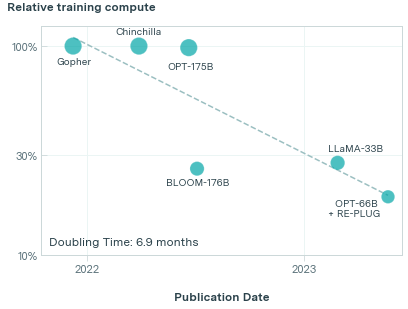

Doubling time of effective compute is 5.9 months using least squares regression
Reference perplexity of GPT-2 is 17.48
min: 16.26, max: 18.79




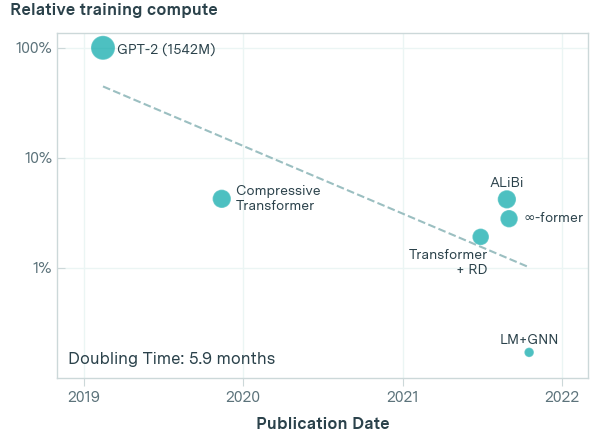

Doubling time of effective compute is 14.9 months using least squares regression
Reference perplexity of Megatron-LM is 19.31
min: 17.55, max: 21.24




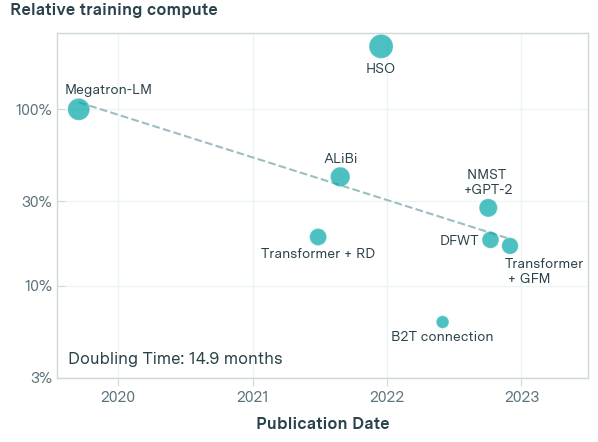

In [24]:
def plot_relative_compute(model, subfigure, x_lim=None, y_lim=None):
    # models = ["Gopher (280B)"]

    with egraphs.epoch_theme():
      fig, ax = plt.subplots(figsize=egraphs.px_to_in((438, 328)))  # Adjust the individual figsize as needed

      # get models within some mutliplicative range defined by a "delta_factor"
      delta_factors = {'Gopher (280B)': 1.25, 'GPT-2 (1542M)': 1.075, 'Megatron-LM (355M)': 1.1}
      delta_factor = delta_factors.get(model, 1.1)

      model_data = dataset[dataset.System == model]
      perplexity = model_data['Perplexity (WT103)'].values[0]
      reference_compute = model_data['Training Compute'].values[0]
      date = model_data['Publication date (df)'].values[0]

      data_subset = dataset[(perplexity/delta_factor < dataset['Perplexity (WT103)']) & (dataset['Perplexity (WT103)'] < perplexity * delta_factor)]
      data_subset = data_subset[data_subset['Publication date (df)'] > pd.to_datetime(date) - pd.Timedelta(days=0.001 * 365)]
      data_subset = data_subset.sort_values('Training Compute', ascending=False).drop_duplicates('Reference')

      if data_subset.shape[0] <= 5:
          print("Skipping", model)
          return

      # prepare data for plotting
      publication_dates = data_subset['Publication date (df)']
      training_compute = data_subset['Training Compute'].values / reference_compute
      systems = data_subset['System'].values

      # calculate statistics
      dates_numeric = mdates.date2num(publication_dates)
      log_training_compute = np.log(training_compute)
      slope, intercept = np.polyfit(dates_numeric, log_training_compute, 1)

      publication_dates_num = data_subset['Publication date']
      slope2, intercept2 = np.polyfit(publication_dates_num, log_training_compute, 1)

      doubling_time = round(-np.log(2) / slope2 * 12, 1)

      # plotting
      if model == "Gopher (280B)":
        shifts = [
            ['Chinchilla',          (-24, +15)],
            ['Gopher',              (-17, -15)],
            ['OPT-175B',            (-21, -18)],
            ['LLaMA-33B',           (-10, 15)],
            ['BLOOM-176B',          (-31, -13)],
            ['OPT-66B \n+ RE-PLUG', (-8,  -10),  {'ha': 'right'}],
        ]
      elif model == "GPT-2 (1542M)":
        shifts = [
          ['GPT-2 (1542M)',             (+10, 0)],
          ['Compressive \nTransformer', (+10, +2)],
          ['ALiBi',                     (0,   +7),  {'va': 'bottom',  'ha': 'center'}],
          ['$\\infty$-former',          (+10, +2)],
          ['Transformer\n   + RD',      (5,   -17), {'ha': 'right'}],
          ['LM+GNN',                    (0,   +4),  {'va': 'bottom',  'ha': 'center'}],
        ]
      elif model == "Megatron-LM (355M)":
        shifts = [
            ['HSO',                 (0,  -12), {'va': 'top', 'ha': 'center'}],
            ['Megatron-LM',         (-10, +15)],
            ['ALiBi',               (0, +8), {'va': 'bottom', 'ha': 'center'}],
            ['NMST \n+GPT-2',       (0, +8), {'va': 'bottom', 'ha': 'center'}],
            ['Transformer + RD',    (0, -8), {'va': 'top', 'ha': 'center'}],
            ['DFWT',                (-8, 0), {'ha': 'right'}],
            ['Transformer\n + GFM', (-4, -17)],
            ['B2T connection',      (0,  -6), {'va': 'top', 'ha': 'center'}],
        ]

      for x, y, shift_value in zip(publication_dates, training_compute, shifts):
          label = shift_value[0]
          shift = shift_value[1]
          extra_args = shift_value[2] if len(shift_value) > 2 else {}
          args = {'va': 'center_baseline', **extra_args}
          ax.annotate(label, xy=(x, y), xytext=shift, xycoords='data', textcoords='offset points', **args)


      sns.lineplot(x=publication_dates, y=np.exp(slope * dates_numeric + intercept), ax=ax, color="#9BBFC1", zorder=1, linestyle='--')
      # sns.scatterplot(x=publication_dates, y=training_compute, ax=ax, s=50, color="black")
      # Scaling factor for marker size
      max_size = 300
      scaling_factor = np.max(log_training_compute) - np.min(log_training_compute)
      sns.scatterplot(x=publication_dates, y=training_compute, ax=ax,
                      size=(log_training_compute + np.abs(np.min(log_training_compute))),
                      sizes=(max_size / scaling_factor, max_size),
                      color="#00A5A6B2", legend=False, edgecolor="#FFFFFF33", linewidth=1, zorder=2)

      model_name = model.split(' ')[0]

      ax.xaxis.set_major_locator(mdates.YearLocator())
      ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

      ax.set_yscale('log')

      if model == "Gopher (280B)":
        ax.set_yticks([1, 0.3, 0.1], labels=['100%', '30%', '10%'])
        scale_factor = 1.2
        days = 10

      elif model == "Megatron-LM (355M)":
        ax.set_yticks([1, 0.3, 0.1, 0.03], labels=['100%', '30%', '10%', '3%'])
        scale_factor = 1.2
        days = 10

      else:
        ax.set_yticks([1, 0.1, 0.01], labels=['100%', '10%', '1%'])
        scale_factor = 1.5
        days = 30

      # Doubling time text settings
      doubling_time_text = f"Doubling Time: {doubling_time} months"
      min_date = publication_dates.min()
      text_x = min_date + pd.Timedelta(days=days)  # Position: slightly to the right of the earliest date

      text_y = ax.get_ylim()[0] * scale_factor
      text_properties = {
          'ha': 'left',
          'va': 'bottom',
          'fontsize': 12,
          # 'fontweight': 'bold',
      }
      ax.annotate(doubling_time_text, xy=(0, 0), xytext=(7.5, 7.5), **text_properties, xycoords='axes fraction', textcoords='offset points')

      ax.set_ylabel(f'Relative training compute')
      ax.set_xlabel('Publication Date')

      print(f"Doubling time of effective compute is {doubling_time} months using least squares regression")
      print(f"Reference perplexity of {model_name} is {perplexity}")
      print(f"min: {round(perplexity/delta_factor,2)}, max: {round(perplexity*delta_factor,2)}")
      print('\n')

      if x_lim: ax.set_xlim(x_lim)
      if y_lim: ax.set_ylim(y_lim)

      plt.minorticks_off()

      egraphs.relayout()

      pdf_filename = f"{model.replace(' ', '_')}_plot.pdf"
      plt.savefig(pdf_filename, format='pdf')

      plt.show()

graphs = [
    {
        'model': "Gopher (280B)",
        'subfigure': 'a',
        'x_lim': [pd.to_datetime('2021-10-15'), pd.to_datetime('2023-06-15')],
        'y_lim': [None, 125e-2]
    },
    {
        'model': "GPT-2 (1542M)",
        'subfigure': 'b',
        'x_lim': [pd.to_datetime('2018-11-01'), pd.to_datetime('2022-03-01')],
        'y_lim': [0.1e-2, None]
    },
    {
        'model': "Megatron-LM (355M)",
        'subfigure': 'c',
        'x_lim': [None, pd.to_datetime('2023-07-01')],
    },
]

for graph in graphs:
    plot_relative_compute(**graph)


# The gains from better scaling laws (Appendix B)

## Setup

In [25]:
import numpy as np
from scipy.optimize import basinhopping
import pandas as pd
import math
import random

In [26]:
#Kaplan
# Define the function L(N, D) as per the provided mathematical formula
def L_kaplan_with_compute(D, compute, alpha_N=0.076, alpha_D=0.103, N_c=6.4e13, D_c=1.8e13):
    # Calculate the function value
    N = compute/(6*D)
    value = ((N_c / N)**(alpha_N / alpha_D) + (D_c / D))**alpha_D
    return value

# Define the new function L(N, D) as per the provided mathematical formula
def L_chinchilla_with_compute(D, compute, E=1.69, A=406.4, B=410.7):
    N = compute / (6 * D)
    # Calculate the function value
    value = E + A / N**0.34 + B / D**0.28
    return value

# Define the new function L(N, D) as per the provided mathematical formula
def L_model_term(D, compute, E=1.69, A=406.4, B=410.7):
    N = compute / (6 * D)
    # Calculate the function value
    value = A / N**0.34
    return value

# Define the new function L(N, D) as per the provided mathematical formula
def L_data_term(D, compute, E=1.69, A=406.4, B=410.7):
    N = compute / (6 * D)
    # Calculate the function value
    value = B / D**0.28
    return value

# A function to perform the basinhopping optimization for L_chinchilla
def optimize_L_chinchilla(compute, initial_guess_D):
    result = basinhopping(
        L_chinchilla_with_compute,  # The function to minimize
        initial_guess_D,  # Initial guess for the variables
        minimizer_kwargs={
            'method': 'L-BFGS-B',
            'bounds': [(initial_guess_D/10000, initial_guess_D*10000)],
            'args': (compute,),  # Additional arguments passed to the objective function
            'options': {'ftol': tolerance},
        },
        niter=max_iterations,
        stepsize=step_size
    )
    return result.x, result.fun

## CEG Chinchilla

In [27]:
# DataFrame to store the results
# Initialize DataFrame to store the results
results_df = pd.DataFrame(columns=[
    'Compute', 'CEG', 'Optimal D (Chinchilla)', 'Optimal D (Kaplan)',
    'Chinchilla Loss', 'Compute_needed Chinchilla to match Kaplan',
    'Loss Chinchilla (with Kaplan scaling)', 'Loss Chinchilla (with Chinchilla scaling)'
])

max_compute = 1e25
min_compute = 1e19

compute_values = np.geomspace(min_compute, max_compute, num=int(np.log2(max_compute/min_compute))+5)

#compute_values = [1e23]

compute = compute_values[0]
initial_guess_D1 = 10*compute**0.5
initial_guess_D2 = 10*compute**0.5

step_size = 0.0005
max_iterations = 10000 #needs to be around 10k

tolerance = 3e-3 # Tolerance for the difference in loss

for compute in compute_values:
  print("compute budget", compute)
  compute_needed = compute

  # Use the basinhopping algorithm to minimize L_kaplan with the given bounds
  result_basinhopping_kaplan = basinhopping(
      L_kaplan_with_compute,  # This function should be defined to accept 'compute' as an argument
      initial_guess_D1,
      minimizer_kwargs={
          'method': 'L-BFGS-B',
          'bounds': [(compute**0.2, compute**0.85)],
          'args': (compute,),  # Pass 'compute' as an additional argument
          'options': {'ftol': tolerance/5}
      },
      niter=max_iterations,
      stepsize=initial_guess_D1*step_size
  )

  # Use the basinhopping algorithm to minimize L_chinchilla with the given bounds
  result_basinhopping_chinchilla = basinhopping(
      L_chinchilla_with_compute,  # This function should be defined to accept 'compute' as an argument
      initial_guess_D2,
      minimizer_kwargs={
          'method': 'L-BFGS-B',
          'bounds': [(compute**0.25, compute**0.85)],
          'args': (compute,),  # Pass 'compute' as an additional argument
          'options': {'ftol': tolerance/5}
      },
      niter=max_iterations,
      stepsize=initial_guess_D2*step_size
  )

  chinchilla_data = result_basinhopping_chinchilla.x[0]
  kaplan_data = result_basinhopping_kaplan.x[0]

  loss_kaplan = L_chinchilla_with_compute(result_basinhopping_kaplan.x, compute)
  loss_chinchilla_1 = L_chinchilla_with_compute(result_basinhopping_chinchilla.x, compute)

  print("optimal data Kaplan", result_basinhopping_kaplan.x)

  print("loss Kaplan-scale", loss_kaplan)
  print("loss Chinchilla-scale", loss_chinchilla_1)


  max_iterations = max_iterations
  for iteration in range(max_iterations):
      initial_guess_D = (chinchilla_data*kaplan_data)**0.5

      # Use the basinhopping algorithm to minimize L_kaplan with the given bounds
      result_basinhopping_chinchilla = basinhopping(
          L_chinchilla_with_compute,  # This function should be defined to accept 'compute' as an argument
          initial_guess_D,
          minimizer_kwargs={
              'method': 'L-BFGS-B',
              'bounds': [(compute_needed**0.2, compute_needed**0.85)],
              'args': (compute_needed,),  # Pass 'compute' as an additional argument
              'options': {'ftol': tolerance}
          },
          niter=max_iterations,
          stepsize=initial_guess_D*step_size
      )

      loss_chinchilla = L_chinchilla_with_compute(result_basinhopping_chinchilla.x, compute_needed)

      print("loss Chinchilla:", loss_chinchilla, "with compute", compute_needed)
      # Compare the chinchilla loss to the kaplan loss
      absolute_difference = abs(loss_chinchilla - loss_kaplan)
      print("loss difference", loss_chinchilla - loss_kaplan)
      print("loss Chinchilla:", loss_chinchilla, "with compute", compute_needed)
      print("loss Kaplan:", loss_kaplan)
      if absolute_difference < tolerance:
          # If the loss is close enough, break the loop
          break
      elif loss_chinchilla < loss_kaplan:
          # If the loss is too low, decrease the compute budget
          delta = (1 + 10*(absolute_difference**2 + random.uniform(0, 1)*absolute_difference))
          compute_needed /= delta  # Directly divide by delta
          print("first elif", compute_needed)
      else:  # This block executes if neither of the above conditions are True
          # If the loss is too high, increase the compute budget
          delta = (1 + 10*(absolute_difference**2 + random.uniform(0, 1)*absolute_difference))
          compute_needed *= delta  # Directly multiply by delta
          print("second elif (now else)", compute_needed)

      print("delta", delta)

  # Print the final compute budget and the corresponding D
  print(f"Compute_needed: {compute_needed}")
  print(f"Chinchilla loss: {loss_chinchilla_1}")
  CEG = compute/compute_needed

  print("Loss Kaplan", L_chinchilla_with_compute(result_basinhopping_kaplan.x,compute))
  print("Checking by plugging D_opt back into chinchilla to check it matches Kaplan loss", L_chinchilla_with_compute(result_basinhopping_chinchilla.x, compute_needed))
  print("CEG", CEG)

  initial_guess_D1 = kaplan_data
  initial_guess_D2 = chinchilla_data

  #L_data = L_data_term(result_basinhopping_kaplan.x, compute)
  #L_model = L_model_term(result_basinhopping_kaplan.x, compute)

  # Creating a DataFrame from a dictionary with the current iteration's results
  iter_results_df = pd.DataFrame({
      'Compute': [compute],
      'CEG': [CEG[0]],  # Assuming CEG is a scalar
      'Optimal D (Chinchilla)': [chinchilla_data],
      'Optimal D (Kaplan)': [kaplan_data],
      'Chinchilla Loss': [loss_chinchilla[0]],
      'Compute_needed Chinchilla to match Kaplan': [compute_needed[0]],
      'Loss Chinchilla (with Kaplan scaling)': [L_chinchilla_with_compute(result_basinhopping_kaplan.x,compute)[0]],
      'Loss Chinchilla (with Chinchilla scaling)': [L_chinchilla_with_compute(result_basinhopping_chinchilla.x,compute)[0]]
  })

  # Append the results of the current iteration to the main results DataFrame
  results_df = pd.concat([results_df, iter_results_df], ignore_index=True)

compute budget 1e+19
optimal data Kaplan [3.74808306e+09]
loss Kaplan-scale [3.01300943]
loss Chinchilla-scale [2.98574135]
loss Chinchilla: [2.9857406] with compute 1e+19
loss difference [-0.02726883]
loss Chinchilla: [2.9857406] with compute 1e+19
loss Kaplan: [3.01300943]
first elif [9.13830299e+18]
delta [1.09429508]
loss Chinchilla: [3.00379362] with compute [9.13830299e+18]
loss difference [-0.00921581]
loss Chinchilla: [3.00379362] with compute [9.13830299e+18]
loss Kaplan: [3.01300943]
first elif [8.98917029e+18]
delta [1.01659026]
loss Chinchilla: [3.00711697] with compute [8.98917029e+18]
loss difference [-0.00589246]
loss Chinchilla: [3.00711697] with compute [8.98917029e+18]
loss Kaplan: [3.01300943]
first elif [8.75298426e+18]
delta [1.02698349]
loss Chinchilla: [3.01251284] with compute [8.75298426e+18]
loss difference [-0.00049659]
loss Chinchilla: [3.01251284] with compute [8.75298426e+18]
loss Kaplan: [3.01300943]
Compute_needed: [8.75298426e+18]
Chinchilla loss: [2.98

In [28]:
results_df_store = results_df.copy()

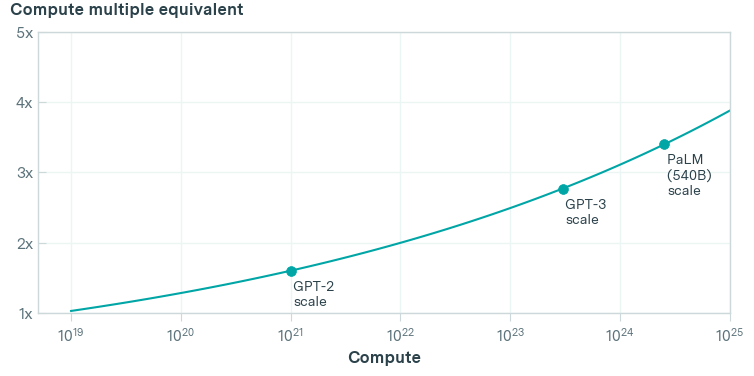

In [29]:
from matplotlib.ticker import FuncFormatter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from matplotlib.ticker import ScalarFormatter  # Import ScalarFormatter

def y_tick_formatter(x, pos):
    return f"{int(x)}x"

# Convert 'CEG' and 'Compute' columns to numeric values, forcing NaNs if conversion fails
#results_df['CEG'] = pd.to_numeric(results_df['CEG'])
#results_df['Compute'] = pd.to_numeric(results_df['Compute'])

# Drop rows with NaN values that resulted from conversion failure
results_df = results_df.dropna(subset=['CEG', 'Compute'])

with egraphs.epoch_theme():
    # Taking the log of 'Compute' and 'CEG'
    log_Compute = np.log(results_df['Compute'])
    log_ceg = np.log(results_df['CEG'])

    gpt_compute = [1.49E+21, 3.4e23, 2.53E+24]

    # Define the log-log function to fit your data (assuming 'log_log_fit' is defined)
    def log_log_fit(x, a, b):
        return a * x + b

    # Perform the curve fit on log-transformed data
    params, covariance = curve_fit(log_log_fit, log_Compute, log_ceg)

    # Extract the fitted parameters
    a_fit, b_fit = params

    # Create a range of log-transformed x values for the fitted line
    x_fit = np.linspace(min(log_Compute), max(log_Compute), 100)

    # Calculate the corresponding log-transformed y values for the fitted line
    y_fit = log_log_fit(x_fit, a_fit, b_fit)

    line_color = '#00A5A6'

    # Plotting the original data and the fitted line on log-log scale
    plt.figure(figsize=(10/1.3, 5/1.3))
    plt.plot(np.exp(x_fit), np.exp(y_fit), label='Fitted Line', linestyle='-', color=line_color)  # Overlay fitted line on the plot

    plt.xscale('log')  # Applying logarithmic scale to x-axis
    #plt.yscale('log')  # Applying logarithmic scale to y-axis

    # Specific point of interest (1e21)
    x_point1 = 1e21
    y_point1 = np.exp(log_log_fit(np.log(x_point1), a_fit, b_fit))

    x_point2 = 3e23
    y_point2 = np.exp(log_log_fit(np.log(x_point2), a_fit, b_fit))

    x_point3 = 2.53E+24
    y_point3 = np.exp(log_log_fit(np.log(x_point3), a_fit, b_fit))

    points = [(x_point1, y_point1), (x_point2, y_point2), (x_point3, y_point3)]

    dot_version = True
    if dot_version:
        plt.scatter([p[0] for p in points], [p[1] for p in points], color=line_color, s=50, zorder=5)
        labels = ['GPT-2 \nscale', 'GPT-3 \nscale', 'PaLM \n(540B) \nscale']
        for point, label in zip(points, labels):
            plt.annotate(label, point, xytext=(+2, -7), textcoords="offset points", va='top', ha='left', fontsize=10)

    else:
        y_offset =  2
        # Adding a horizontal line from x_point1 to the fitted curve
        plt.hlines(y_point1, 0, x_point1, colors='gray', linestyles='dashed')
        plt.hlines(y_point2, 0, x_point2, colors='gray', linestyles='dashed')
        plt.hlines(y_point3, 0, x_point3, colors='gray', linestyles='dashed')

        plt.vlines(x_point1, 0, y_point1, colors='gray', linestyles='dashed')
        plt.text(x_point1, y_point1/y_offset+0.25, 'GPT-2 scale', rotation=0, verticalalignment='bottom', fontsize=10)

        plt.vlines(x_point2, 0, y_point2, colors='gray', linestyles='dashed')
        plt.text(x_point2/6, y_point2/y_offset, 'GPT-3 scale', rotation=0, verticalalignment='bottom', fontsize=10)

        plt.vlines(x_point3, 0, y_point3, colors='gray', linestyles='dashed')
        plt.text(x_point3/7, y_point3/y_offset, 'PaLM (540B)\n scale', rotation=0, verticalalignment='bottom', fontsize=10)

    plt.xticks()
    plt.yticks([1, 2, 3, 4, 5])

    plt.ylim(1,5)
    plt.xlim(5e18,1e25)

    plt.xlabel('Compute')
    plt.ylabel('Compute multiple equivalent')
    plt.grid(True)

    plt.gca().yaxis.set_major_formatter(FuncFormatter(y_tick_formatter))

    plt.minorticks_off()

    egraphs.relayout()

    # Save the plot as a PDF
    plt.savefig('ceg.pdf', format='pdf')

    plt.show()

## Checking empirical CEG values

In [30]:
GPT_3_compute = 3e23
PaLM_compute = 2.53e24

PaLM_param = 540*10**9
PaLM_data = 780*10**9

GPT_param = 175*10**9
GPT_data = 300*10**9

compute_values = 2.53E+24

step_size = 0.0005
max_iterations = 10000

tolerance = 1e-4 # Tolerance for the difference in loss

results_df_empirical = pd.DataFrame(columns=[
    'Compute', 'CEG', 'Actual loss', 'Chinchilla Loss',
    'Actual data', 'Chinchilla data', 'Data needed lower compute budget'
    ])

compute_values = [GPT_3_compute,PaLM_compute]

for compute in compute_values:
  print("compute budget", compute)

  # Use the basinhopping algorithm to minimize L_chinchilla with the given bounds
  result_basinhopping_chinchilla = basinhopping(
      L_chinchilla_with_compute,  # This function should be defined to accept 'compute' as an argument
      compute**0.5,
      minimizer_kwargs={
          'method': 'L-BFGS-B',
          'bounds': [(compute**0.25, compute**0.85)],
          'args': (compute,),  # Pass 'compute' as an additional argument
          'options': {'ftol': tolerance/5}
      },
      niter=max_iterations,
      stepsize=initial_guess_D2*step_size
  )

  chinchilla_data = result_basinhopping_chinchilla.x[0]

  if compute == GPT_3_compute:
    actual_data = GPT_data
  else:
    actual_data = PaLM_data

  loss_actual = L_chinchilla_with_compute(actual_data, compute)

  loss_chinchilla_1 = L_chinchilla_with_compute(result_basinhopping_chinchilla.x, compute)

  print("loss actual", loss_actual)
  print("loss Chinchilla-scale", loss_chinchilla_1)

  compute_needed = compute

  max_iterations = max_iterations
  for iteration in range(max_iterations):
      initial_guess_D = chinchilla_data

      # Use the basinhopping algorithm to minimize L_kaplan with the given bounds
      result_basinhopping_chinchilla = basinhopping(
          L_chinchilla_with_compute,  # This function should be defined to accept 'compute' as an argument
          initial_guess_D,
          minimizer_kwargs={
              'method': 'L-BFGS-B',
              'bounds': [(compute_needed**0.2, compute_needed**0.85)],
              'args': (compute_needed,),  # Pass 'compute' as an additional argument
              'options': {'ftol': tolerance}
          },
          niter=max_iterations,
          stepsize=initial_guess_D*step_size
      )

      loss_chinchilla = L_chinchilla_with_compute(result_basinhopping_chinchilla.x, compute_needed)[0]

      #print("loss Chinchilla:", loss_chinchilla, "with compute", compute_needed)
      # Compare the chinchilla loss to the kaplan loss
      absolute_difference = abs(loss_chinchilla - loss_actual)
      print("loss actual", loss_actual)
      print("loss chinchilla", loss_chinchilla)
      print("loss diference", loss_chinchilla - loss_actual)
      print("compute needed", compute_needed)
      print("loss", L_chinchilla_with_compute(result_basinhopping_chinchilla.x,compute_needed))
      if absolute_difference < tolerance:
          # If the loss is close enough, break the loop
          break
      elif loss_chinchilla < loss_actual:
          # If the loss is too low, decrease the compute budget
          delta = (1 + 10*(absolute_difference + random.uniform(0, 0.005))+ random.uniform(0, 0.01))

          compute_needed /= delta
      else:
          # If the loss is too high, increase the compute budget
          compute_needed *= delta

  # Print the final compute budget and the corresponding D
  print(f"Loss chinchilla with lower compute budget: {loss_chinchilla}")
  print(f"Loss actual: {loss_actual}")
  print(f"Compute_needed: {compute_needed}")
  CEG = compute/compute_needed

  # Creating a DataFrame from a dictionary with the current iteration's results
  iter_results_df = pd.DataFrame({
      'Compute': [compute],
      'CEG': [CEG],  # Assuming CEG is a scalar
      'Actual loss': [loss_actual],
      'Chinchilla Loss': [loss_chinchilla_1],
      'Actual data': [actual_data],
      'Chinchilla data': [chinchilla_data],
      'Data needed lower compute budget': [result_basinhopping_chinchilla.x[0]]
  })

  # Append the results of the current iteration to the main results DataFrame
  results_df_empirical = pd.concat([results_df_empirical, iter_results_df], ignore_index=True)

compute budget 3e+23
loss actual 2.0033106150032607
loss Chinchilla-scale [1.9561113]
loss actual 2.0033106150032607
loss chinchilla 1.9561113009830648
loss diference -0.04719931402019584
compute needed 3e+23
loss [1.9561113]
loss actual 2.0033106150032607
loss chinchilla 1.9724039004675025
loss diference -0.030906714535758217
compute needed 2.0372675207947563e+23
loss [1.9724039]
loss actual 2.0033106150032607
loss chinchilla 1.9848196520351444
loss diference -0.018490962968116254
compute needed 1.5394131622410587e+23
loss [1.98481965]
loss actual 2.0033106150032607
loss chinchilla 1.9940566446680164
loss diference -0.009253970335244333
compute needed 1.259310454439824e+23
loss [1.99405664]
loss actual 2.0033106150032607
loss chinchilla 1.9985729757249282
loss diference -0.004737639278332484
compute needed 1.143921869113451e+23
loss [1.99857298]
loss actual 2.0033106150032607
loss chinchilla 2.001593267680978
loss diference -0.0017173473222826807
compute needed 1.0736109676476709e+23


In [31]:
results_df_empirical

,Compute,CEG,Actual loss,Chinchilla Loss,Actual data,Chinchilla data,Data needed lower compute budget
0,3.000000e+23,2.896648,2.003311,[1.9561113010958242],300000000000,2.085616e+12,1.162054e+12
1,2.530000e+24,3.635618,1.923859,[1.8818128229211233],780000000000,6.709050e+12,3.306493e+12


# Core model param estimates (Appendix C)

## Scaling law graph

In [32]:
model_num = 7
delta = 0.0025

filename_suffix = f'_model{model_num}_delta{delta}_bootstrap_results.json'

latest_cached_filename = safe_max([f for f in os.listdir() if f.endswith(filename_suffix)])

filename = latest_cached_filename
#filename = '2024-01-18_model7_delta0.0025_bootstrap_results.json'

with open(filename, 'r') as f:
    bootstrap_results = json.load(f)
bootstrap_results = np.array(bootstrap_results)

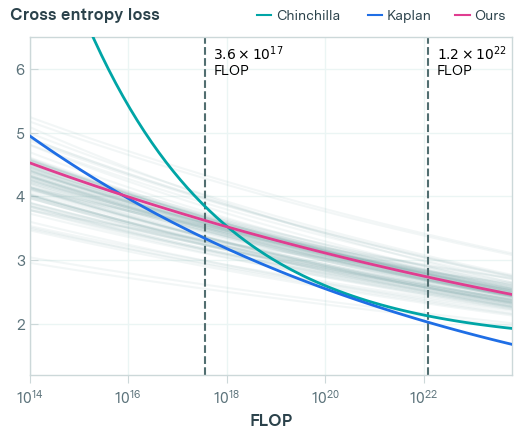

In [33]:
with egraphs.epoch_theme():
  ci = 80

  df1 = df_head[["publication_date", "dataset", "param", "log_ppl"]].copy()
  df1["compute"] = 6 * df1["dataset"] * df1["param"]
  df_sorted = df1.sort_values(by=["compute"])

  # min_compute, compute1, compute2, max_compute = np.percentile(df_sorted["compute"], [0, 50 - ci/2, 50 + ci/2, 100])

  min_compute, compute1, compute2, max_compute = np.percentile(df_head["Training Compute"].dropna(), [0, 50 - ci/2, 50 + ci/2, 100])

  # df_filtered = df_sorted[(df_sorted['compute'] >= compute1) & (df_sorted['compute'] <= compute2)].copy()
  # df_filtered
  # print(f"{min_compute:.2e} FLOP, {compute1:.2e} FLOP, {compute2:.2e} FLOP, {max_compute:.2e} FLOP")

  def chinchilla(estimates, compute):
    """
    chinchilla scaling law
    optimal data and optimal param determined by eq 4 in the paper
    https://arxiv.org/pdf/2203.15556.pdf
    """
    ir, a, b, alpha, beta = estimates.values()

    g = ((alpha * a) / (beta * b)) ** (1 / (alpha + beta))
    param_share = beta / (alpha + beta)
    param_opt = g * (compute / 6) ** param_share
    data_opt = 1 / g * (compute / 6) ** (1 - param_share)

    param_terms = a / param_opt ** alpha
    data_terms = b / data_opt ** beta

    return ir + param_terms + data_terms

  def kaplan(estimates, compute):
    """
    scaling law from figure 5 here https://arxiv.org/pdf/2010.14701.pdf
    """
    coefficient, exponent = estimates.values()

    mystery_factor = 1#1.043
    petaflop_day = 1e15 * 24 * 3600

    return mystery_factor * coefficient * (compute / petaflop_day) ** exponent

  def ours(estimates, compute, year=2023, year_const=2012, param_const=1e8, data_const=1e8):
    alpha_const, alpha_const_ptb, alpha_const_wt2, alpha_year, alpha_param, \
    beta_const, beta_const_ptb, beta_const_wt2, beta_year, beta_data = estimates

    a = np.exp(alpha_const) * param_const ** alpha_param
    b = np.exp(beta_const) * data_const ** beta_data
    g = ((alpha_param * a) / (beta_data * b)) ** (1 / (alpha_param + beta_data))
    param_share = beta_data / (alpha_param + beta_data)
    param_opt = g * (compute / 6) ** param_share
    data_opt = 1 / g * (compute / 6) ** (1 - param_share)

    alpha_terms = np.exp(alpha_const - alpha_year * (year - year_const) - alpha_param * np.log(param_opt / param_const))
    beta_terms = np.exp(beta_const - beta_year * (year - year_const) - beta_data * np.log(data_opt / data_const))

    return 0.1 + alpha_terms + beta_terms

  scaling_laws = [
      {
          "name": "Chinchilla",
          "function": chinchilla,
          "estimates": {"ir": 1.69, "a": 406.4, "b": 410.7, "alpha": 0.34, "beta": 0.28},
          "min_compute": 1e14, #6e18,
          "max_compute": 5e23,
      },
      {
          "name": "Kaplan",
          "function": kaplan,
          "estimates": {"coefficient": 2.57, "exponent": -0.048},
          "min_compute": 1e14,
          "max_compute": 4e23
      },
      {
          "name": "Ours",
          "function": ours,
          "estimates": bootstrap_results,
          "min_compute": 1e14, # 1e14,
          "max_compute": 4e23#5e23
      }
  ]

  num_points = 100

  plt.figure(figsize=(egraphs.px_to_in((373, 322))))

  for scaling_law in scaling_laws:
    min_compute, max_compute = scaling_law["min_compute"], scaling_law["max_compute"]
    compute_vals = np.exp(np.linspace(np.log(min_compute), np.log(max_compute) * 1.2, num_points))

    color = {
      'Ours': '#E03D90',
      'Kaplan': '#1F6EE5',
      'Chinchilla': '#00A5A6',
    }[scaling_law["name"]]

    if scaling_law["name"] == "Ours":
      for i in range(len(bootstrap_results)):
        loss_vals = [scaling_law["function"](scaling_law["estimates"][i], compute) for compute in compute_vals]
        if i == 0:
          plt.plot(compute_vals, loss_vals, label=scaling_law["name"], lw=2, color=color, zorder=3)
        else:
          plt.plot(compute_vals, loss_vals, alpha=0.1, color="#85ADAF")
    else:
      loss_vals = [scaling_law["function"](scaling_law["estimates"], compute) for compute in compute_vals]
      plt.plot(compute_vals, loss_vals, label=scaling_law["name"], lw=2, color=color, zorder=3)


  # vertical lines to show where most of the data is found
  plt.axvline(x=compute1, color='#516E70', linestyle='--')
  plt.axvline(x=compute2, color='#516E70', linestyle='--')

  def format_scientific(num):
      if num == 0:
          return "0"
      exponent = np.floor(np.log10(np.abs(num)))
      coefficient = num / 10**exponent
      return r"${:.1f} \times 10^{{{}}}$".format(coefficient, int(exponent))

  formatted_compute1 = format_scientific(compute1)
  formatted_compute2 = format_scientific(compute2)
  plt.text(compute1 * 1.5, 6.40, f'{formatted_compute1} \nFLOP', color='black', va='top')
  plt.text(compute2 * 1.5, 6.40, f'{formatted_compute2} \nFLOP', color='black', va='top')

  plt.xscale("log")
  plt.xlabel("FLOP")
  plt.xlim(1e14, 4 * 10**23.2)
  plt.ylim(bottom=1.2, top=6.5)
  plt.ylabel("Cross entropy loss")
  plt.legend(loc="upper right")

  egraphs.relayout(legend=dict(item_spacing=20, symbol_width=12), replace_legend=True)

  plt.gcf().subplots_adjust(left=egraphs.px_to_x_fraction(20), right=1-egraphs.px_to_x_fraction(10))


  filename = f"{date}_comparing-scaling-laws.pdf"
  plt.savefig(filename)
  files.download(filename)

  plt.show()

## Comparing $\alpha_\text{year}$ and $\beta_\text{year}$

In [70]:
filename_suffix = f'_main_model_1000_bootstraps.json'

latest_cached_filename = safe_max([f for f in os.listdir() if f.endswith(filename_suffix)])

filename = latest_cached_filename
#filename = '2024-02-26_main_model_1000_bootstraps.json'

print(filename)

with open(filename, 'r') as f:
    bootstrap_results = json.load(f)
bootstrap_results = np.array(bootstrap_results)

2024-02-26_main_model_1000_bootstraps.json


In [71]:
alpha_year = np.array(bootstrap_results).T[3]
beta_year = np.array(bootstrap_results).T[8]

data = {"alpha_year": alpha_year, "beta_year": beta_year}
df_compare = pd.DataFrame(data)
df_compare["below_diag"] = df_compare["beta_year"] < -df_compare["alpha_year"]
proportion_below = sum(df_compare["beta_year"] < -df_compare["alpha_year"]) / len(df_compare)
proportion_above = 1 - proportion_below
print(proportion_above, proportion_below)

0.952 0.048


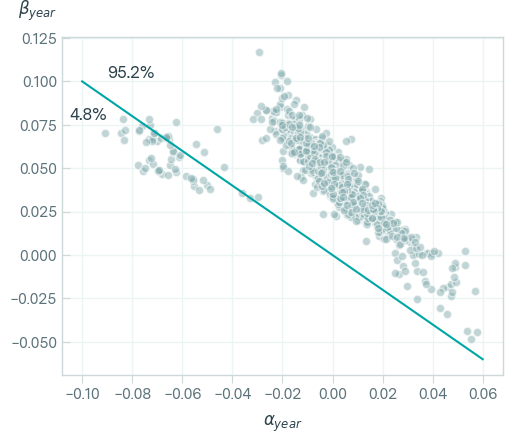

In [76]:
with egraphs.epoch_theme():
    plt.figure(figsize=(egraphs.px_to_in((373, 322))))

    x = np.linspace(-0.1, 0.06)
    y = -x
    plt.plot(x, y, color="#00A5A6")

    plt.scatter(np.array(bootstrap_results).T[3], np.array(bootstrap_results).T[8], alpha=0.5, color='#85ADAF66',
                edgecolors='#FFFFFF33', linewidths=1)
    plt.xlabel(r"$\alpha_{year}$")
    plt.ylabel(r"$\beta_{year}$")
    plt.tick_params(axis="both")
    plt.text(-0.09, 0.102, f"{proportion_above * 100:.1f}%", fontsize=12)
    plt.text(-0.105, 0.078, f"{proportion_below * 100:.1f}%", fontsize=12)

    egraphs.relayout()

    # Why is the y axis label so unaligned?
    # Doesn't matter, let's hack our way around it
    plt.gca().yaxis.labelpad = -6

    plt.savefig("alpha-beta-year-correlation.pdf")

    plt.show()

# Significance of the transformer (Appendix D)

In [81]:
# Sorted list of models from LOOCV

text = '''
MSE_model10_delta0.001 with MSE: 0.04847642103308974
MSE_model7_delta0.0025 with MSE: 0.048563819600523625
MSE_model15_delta0.01 with MSE: 0.04862315855821884
MSE_model8_delta0.005 with MSE: 0.04869930867235716
MSE_model15_delta0.005 with MSE: 0.048837041442145145
MSE_model7_delta0.01 with MSE: 0.04891918602256304
MSE_model12_delta0.02 with MSE: 0.048973521894055565
MSE_model10_delta0.0025 with MSE: 0.04900021080864785
MSE_model10_delta0.005 with MSE: 0.04912598962168982
MSE_model12_delta0.005 with MSE: 0.04919516440616078
MSE_model7_delta0.02 with MSE: 0.049196912806226865
MSE_model15_delta0.02 with MSE: 0.049208871605081556
MSE_model9_delta0.02 with MSE: 0.0492496779731775
MSE_model15_delta0.0025 with MSE: 0.0493659178353991
MSE_model12_delta0.0025 with MSE: 0.04939151143709678
MSE_model12_delta0 with MSE: 0.04945719102884973
MSE_model7_delta0.005 with MSE: 0.04951969534757872
MSE_model8_delta0.001 with MSE: 0.04953478220039427
MSE_model9_delta0.01 with MSE: 0.049633670324652365
MSE_model10_delta0 with MSE: 0.0496386829123009
MSE_model15_delta0.001 with MSE: 0.04974714962652067
MSE_model8_delta0.0025 with MSE: 0.04975454905094963
MSE_model9_delta0.001 with MSE: 0.04996074827356605
MSE_model12_delta0.001 with MSE: 0.04996603261650825
MSE_model5_delta0.0025 with MSE: 0.05004010021793135
MSE_model13_delta0.01 with MSE: 0.050051494030613965
MSE_model8_delta0 with MSE: 0.05006104716119326
MSE_model5_delta0.01 with MSE: 0.050067874896543366
MSE_model10_delta0.01 with MSE: 0.05008937352919118
MSE_model5_delta0.001 with MSE: 0.050102107801012694
MSE_model5_delta0 with MSE: 0.05011472488781519
MSE_model12_delta0.01 with MSE: 0.05012300076011561
MSE_model5_delta0.005 with MSE: 0.05014520136923527
MSE_model6_delta0.0025 with MSE: 0.05017838046649957
MSE_model13_delta0.02 with MSE: 0.05018254165191081
MSE_model6_delta0.001 with MSE: 0.050211502555967645
MSE_model7_delta0.001 with MSE: 0.050280869617072406
MSE_model13_delta0.005 with MSE: 0.050282769705482254
MSE_model6_delta0.005 with MSE: 0.050300335175406864
MSE_model6_delta0 with MSE: 0.05033529325347098
MSE_model9_delta0.005 with MSE: 0.05042332825343481
MSE_model7_delta0 with MSE: 0.05048628122937888
MSE_model6_delta0.01 with MSE: 0.05049228245320385
MSE_model9_delta0 with MSE: 0.05049983060306857
MSE_model15_delta0 with MSE: 0.050679997980066255
MSE_model13_delta0.0025 with MSE: 0.050698150865848335
MSE_model9_delta0.0025 with MSE: 0.050967766422513536
MSE_model11_delta0.01 with MSE: 0.0510147019882579
MSE_model10_delta0.02 with MSE: 0.05105248468078686
MSE_model5_delta0.02 with MSE: 0.05113333396716201
MSE_model4_delta0.0025 with MSE: 0.05114297501006555
MSE_model4_delta0 with MSE: 0.05117703202357158
MSE_model4_delta0.001 with MSE: 0.05120147853188074
MSE_model11_delta0.02 with MSE: 0.05127244185762453
MSE_model4_delta0.005 with MSE: 0.051340642077796865
MSE_model6_delta0.02 with MSE: 0.0516182611825561
MSE_model11_delta0.001 with MSE: 0.05185697447326047
MSE_model11_delta0.0025 with MSE: 0.05195536728725606
MSE_model4_delta0.02 with MSE: 0.051991532153223115
MSE_model8_delta0.01 with MSE: 0.05208277509942345
MSE_model3_delta0.02 with MSE: 0.052221513063791865
MSE_model13_delta0 with MSE: 0.052266869604816205
MSE_model4_delta0.01 with MSE: 0.05227314125905681
MSE_model11_delta0.005 with MSE: 0.052300870090183464
MSE_model1_delta0.02 with MSE: 0.05231041850093214
MSE_model3_delta0.01 with MSE: 0.05235382460770766
MSE_model3_delta0.005 with MSE: 0.052486395797718924
MSE_model8_delta0.02 with MSE: 0.052500864949434
MSE_model3_delta0.0025 with MSE: 0.0526157447228351
MSE_model13_delta0.001 with MSE: 0.05267303735461852
MSE_model1_delta0.01 with MSE: 0.05280640607843129
MSE_model11_delta0 with MSE: 0.05280884897040363
MSE_model3_delta0.001 with MSE: 0.05290070492885797
MSE_model3_delta0 with MSE: 0.05293832875988481
MSE_model1_delta0.005 with MSE: 0.052946944362773175
MSE_model1_delta0 with MSE: 0.05304287899814275
MSE_model1_delta0.0025 with MSE: 0.05308409582414382
MSE_model1_delta0.001 with MSE: 0.05309104778457573
MSE_model2_delta0.001 with MSE: 0.05370188343780064
MSE_model2_delta0 with MSE: 0.053708611467090626
MSE_model2_delta0.0025 with MSE: 0.053929303217719
MSE_model2_delta0.005 with MSE: 0.058523467750504106
MSE_model2_delta0.01 with MSE: 0.05859924480221594
MSE_model2_delta0.02 with MSE: 0.059214191942178425
MSE_model14_delta0.01 with MSE: 0.0630178550258326
MSE_model16_delta0.02 with MSE: 0.06310033058892191
MSE_model14_delta0 with MSE: 0.06314328323043893
MSE_model14_delta0.02 with MSE: 0.06335670195075582
MSE_model14_delta0.005 with MSE: 0.06358520065342112
MSE_model14_delta0.001 with MSE: 0.06377413967870402
MSE_model17_delta0.02 with MSE: 0.06411190728148224
MSE_model17_delta0.01 with MSE: 0.06421223220480772
MSE_model17_delta0 with MSE: 0.06427032146119384
MSE_model16_delta0.01 with MSE: 0.06431442632611813
MSE_model17_delta0.001 with MSE: 0.06471762070756258
MSE_model17_delta0.005 with MSE: 0.06474683211854922
MSE_model16_delta0.005 with MSE: 0.06486091163166682
MSE_model14_delta0.0025 with MSE: 0.06519946570962575
MSE_model17_delta0.0025 with MSE: 0.06536816974606262
MSE_model16_delta0 with MSE: 0.06598972281472236
MSE_model16_delta0.001 with MSE: 0.06662594805175184
MSE_model16_delta0.0025 with MSE: 0.06700852485053925
'''

In [82]:
model_delta_pairs = re.findall("model\d+_delta\d.\d+", text)
# unique_model_num = []
names = []
selected_models = []

for i, pair in enumerate(model_delta_pairs):
  model_num = int(re.search("\d+", pair)[0])
  delta = float(re.search("\d.\d+", pair)[0])
  names.append([model_num, delta])
  selected_models.append([globals()[f"model_{model_num}"], delta]) # model_name, delta

  if (i + 1) % 10 == 0:
    break
  # if not (model_num in unique_model_num):
  #   unique_model_num.append(model_num)
  #   names.append([model_num, delta])

names

[[10, 0.001],
 [7, 0.0025],
 [15, 0.01],
 [8, 0.005],
 [15, 0.005],
 [7, 0.01],
 [12, 0.02],
 [10, 0.0025],
 [10, 0.005],
 [12, 0.005]]

In [83]:
from scipy.optimize import brentq

# define main functions
def transformer_model(params, year, param, dataset, category_ptb, category_wt2, transformer, model):
    """
    don't use this with model 13
    """
    params_other, gamma_transformer = params[:-1], params[-1]

    transformer_improvement = 1 / (1+np.exp(-gamma_transformer))
    model_pred = model(params_other, year, param, dataset, category_ptb, category_wt2)

    return transformer * transformer_improvement * model_pred + (1 - transformer) * model_pred

def transformer_residuals(params, year, param, dataset, category_ptb, category_wt2, transformer, log_ppl, model, delta):
    residuals = log_ppl - transformer_model(params, year, param, dataset, category_ptb, category_wt2, transformer, model)
    l1_reg = delta * np.sum(np.abs(params))
    return np.mean(np.square(residuals)) + l1_reg

def predict_with_bootstrap(bootstrap_params, year, param, dataset, category_ptb, category_wt2, transformer, model):
    predictions = []
    for params in bootstrap_params:
        prediction = transformer_model(params, year, param, dataset, category_ptb, category_wt2, transformer, model)
        predictions.append(prediction)
    return predictions

def find_a_for_equal_predictions(params, year, param_input, dataset_input, category_ptb, category_wt2, model):
    # Function to find the root (where transformer and non-transformer predictions are equal)
    def equation(a):
        transformer_pred = transformer_model(params, year, param_input, dataset_input, category_ptb, category_wt2, 1, model)
        non_transformer_pred = transformer_model(params, year, a*param_input, a*dataset_input, category_ptb, category_wt2, 0, model)
        # print(transformer_pred - non_transformer_pred)
        return transformer_pred - non_transformer_pred

    # Define lower and upper bounds for 'a'
    a_lower = 0.01  # Adjust as needed based on the expected range of 'a'
    a_upper = 100   # Adjust as needed

    # Solve for 'a' using brentq
    a_solution = brentq(equation, a_lower, a_upper)
    return a_solution

Run the following cell if you just want to plot graphs and not the bootstraps

In [84]:
df_double = df_head.copy(deep=True)
df_double['transformer'] = df_double['Architecture'].apply(lambda x: 1 if x == 'Transformer' else 0).astype(int)

param_const = np.min(df_double["param"])
dataset_const = np.min(df_double["dataset"])

year = df_double["publication_date"]
param = df_double["param"]
dataset = df_double["dataset"]
log_ppl = df_double["log_ppl"]
dataset_ptb = df_double['ptb_dummy']
dataset_wt2 = df_double['wt2_dummy']
transformer = df_double['transformer']

year_const = min(year)
data_const = min(dataset)
param_const = min(param)

## Bootstraps (skip if you only want graphs)

In [86]:
filename_suffix = f'_aggregated_transformer_bootstrap_estimates.json'
latest_cached_filename = safe_max([f for f in os.listdir() if f.endswith(filename_suffix)])

In [87]:
if not (use_cached_bootstraps and latest_cached_filename):
  n_bootstrap_samples = 100
  np.random.seed(0)

  df_double_transformer = df_head.copy(deep=True)
  df_double_transformer['transformer'] = df_double_transformer['Architecture'].apply(lambda x: 1 if x == 'Transformer' else 0).astype(int)

  year = df_double_transformer["publication_date"]
  param = df_double_transformer["param"]
  dataset = df_double_transformer["dataset"]
  log_ppl = df_double_transformer["log_ppl"]
  dataset_ptb = df_double_transformer['ptb_dummy']
  dataset_wt2 = df_double_transformer['wt2_dummy']
  transformer = df_double_transformer['transformer']

  param_const = np.min(param)
  dataset_const = np.min(dataset)
  year_const = np.min(year)

  all_bootstrap_results = []
  for model, delta in selected_models:
      model_num_str = re.search(r'\d+', model.__name__).group()
      model_num = int(model_num_str)

      print(f"Model number = {model_num}, delta = {delta}")

      num_params = num_params_in_model(model_num) + 1
      p0 = np.zeros(num_params)

      bootstrap_results = []
      for i in range(n_bootstrap_samples):
        bootstrap_indices = np.random.choice(np.array(log_ppl.index), size=len(log_ppl), replace=True)
        bootstrap_log_ppl = log_ppl[bootstrap_indices]

        bootstrap_res = minimize(transformer_residuals, p0, args=(year[bootstrap_indices], param[bootstrap_indices], dataset[bootstrap_indices], \
                      dataset_ptb[bootstrap_indices], dataset_wt2[bootstrap_indices], transformer[bootstrap_indices], log_ppl[bootstrap_indices], \
                                                                  model, delta), method='SLSQP')
        bootstrap_results.append(bootstrap_res.x)

        if i % 5 == 4:
            print(f"Bootstrap steps complete: ({i+1}/{n_bootstrap_samples})")
      print("\n")

      all_bootstrap_results.append(bootstrap_results)

Model number = 10, delta = 0.001
Bootstrap steps complete: (5/100)
Bootstrap steps complete: (10/100)
Bootstrap steps complete: (15/100)
Bootstrap steps complete: (20/100)
Bootstrap steps complete: (25/100)
Bootstrap steps complete: (30/100)
Bootstrap steps complete: (35/100)
Bootstrap steps complete: (40/100)
Bootstrap steps complete: (45/100)
Bootstrap steps complete: (50/100)
Bootstrap steps complete: (55/100)
Bootstrap steps complete: (60/100)
Bootstrap steps complete: (65/100)
Bootstrap steps complete: (70/100)
Bootstrap steps complete: (75/100)
Bootstrap steps complete: (80/100)
Bootstrap steps complete: (85/100)
Bootstrap steps complete: (90/100)
Bootstrap steps complete: (95/100)
Bootstrap steps complete: (100/100)


Model number = 7, delta = 0.0025
Bootstrap steps complete: (5/100)
Bootstrap steps complete: (10/100)
Bootstrap steps complete: (15/100)
Bootstrap steps complete: (20/100)
Bootstrap steps complete: (25/100)
Bootstrap steps complete: (30/100)
Bootstrap steps complet

In [89]:
if use_cached_bootstraps and latest_cached_filename:
      with open(latest_cached_filename, 'r') as f:
            bootstrap_results = json.load(f)
else:
    all_bootstrap_results_to_save = [
        [param_estimates.tolist() if isinstance(param_estimates, np.ndarray) else param_estimates for param_estimates in model_bootstrap_results]
        for model_bootstrap_results in all_bootstrap_results
    ]

    filename = f"{date}_aggregated_transformer_bootstrap_estimates.json"
    with open(filename, 'w') as f:
        json.dump(all_bootstrap_results_to_save, f)

    files.download(filename)

## Graphs

In [90]:
custom_filename_to_load = None # @param {type:"string"}
#custom_filename_to_load = '2024-01-12_transformer_bootstrap_results.json'
if custom_filename_to_load:
    with open(custom_filename_to_load, 'r') as f:
        bootstrap_results = json.load(f)
    bootstrap_results = np.array(bootstrap_results)

In [91]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

In [92]:
# inputs
compute = 1e25
param_input = (compute/6)**0.5  # compute = 6nd, assuming equal split between data and param
dataset_input = (compute/6)**0.5  # compute = 6nd, assuming equal split between data and param
category_ptb_input = 0  # Example: 0 or 1
category_wt2_input = 0  # Example: 0 or 1
year_input = 2023

models = [model[0] for model in selected_models]

all_a_values = []
all_ceg_values = []


for i, bootstrap_results in enumerate(all_bootstrap_results):
    # if names[i][0] == 6: pass
    # else:
      print(f"Model num = {names[i][0]}, delta = {names[i][1]}")
      a_values = [find_a_for_equal_predictions(params, year_input, param_input, dataset_input, category_ptb_input, category_wt2_input, models[i]) for params in bootstrap_results]
      ceg_values = [a ** 2 for a in a_values]
      all_a_values.append(a_values)
      all_ceg_values.append(ceg_values)

      print("2.5 percentile", np.percentile(ceg_values, 2.5))
      print("Median", np.median(ceg_values))
      print("97.5 percentile",  np.percentile(ceg_values, 97.5))
      print("\n")

Model num = 10, delta = 0.001
2.5 percentile 1.90853634742866
Median 3.960135390678867
97.5 percentile 16.165739718303843


Model num = 7, delta = 0.0025
2.5 percentile 2.9857497794992662
Median 7.567080876351951
97.5 percentile 159.0288434602767


Model num = 15, delta = 0.01
2.5 percentile 11.32165259515067
Median 35.4536139882484
97.5 percentile 248.3880433600504


Model num = 8, delta = 0.005
2.5 percentile 5.887549406378708
Median 17.667624295409333
97.5 percentile 96.44353777489741


Model num = 15, delta = 0.005
2.5 percentile 5.51933413404104
Median 14.145562350591744
97.5 percentile 99.42989646716377


Model num = 7, delta = 0.01
2.5 percentile 11.867987125342696
Median 40.06288232244719
97.5 percentile 928.5034299968629


Model num = 12, delta = 0.02
2.5 percentile 64.12823233482445
Median 250.88808816818923
97.5 percentile 2322.4217294123773


Model num = 10, delta = 0.0025
2.5 percentile 3.4609085207471777
Median 7.879917322480455
97.5 percentile 32.321661376820934


Model 

/tmp/ipykernel_191768/807481536.py:11: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(y="CEG", x="Model", data=df, palette=egraphs.get_gradient_colors(len(all_ceg_values) + 2)[::-1], s=5, ax=ax)
/tmp/ipykernel_191768/807481536.py:11: UserWarning: The palette list has more values (12) than needed (10), which may not be intended.
  sns.swarmplot(y="CEG", x="Model", data=df, palette=egraphs.get_gradient_colors(len(all_ceg_values) + 2)[::-1], s=5, ax=ax)
/home/edu/.local/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 86.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/edu/.local/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 81.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/edu/.local/lib/python3.10/site-packages/seab

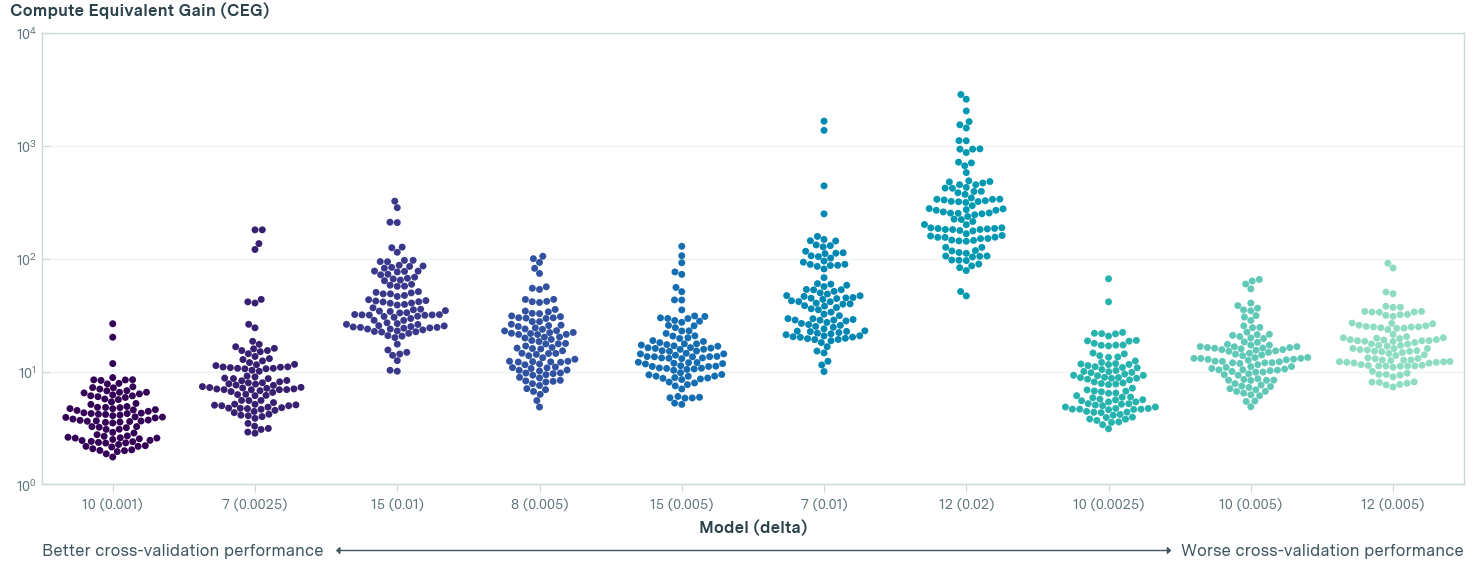

In [97]:
from matplotlib.patches import FancyArrowPatch

def scatter_plot_transformer(all_ceg_values, ci, filename, names, data_filter):
    with egraphs.epoch_theme():
        data = []
        for i, ceg_values in enumerate(all_ceg_values):
            data.append({'model': f'{names[i][0]} ({names[i][1]})', 'value': data_filter(ceg_values, ci)})
        df = pd.DataFrame([(d['model'], val) for d in data for val in d['value']], columns=['Model', 'CEG'])

        fig, ax = plt.subplots(figsize=(15, 6))
        sns.swarmplot(y="CEG", x="Model", data=df, palette=egraphs.get_gradient_colors(len(all_ceg_values) + 2)[::-1], s=5, ax=ax)

        arrow_y = 0.26

        arrow_color = '#3E555E'
        arrow_style = "<|-|>,head_width=2,head_length=2"

        arrow_left_text = mpl.text.Text(-0.5, arrow_y, 'Better cross-validation performance', fontsize=12, color=arrow_color,
                ha='left', va='center', weight='medium', clip_on=False)
        arrow_right_text = mpl.text.Text(9.5, arrow_y, 'Worse cross-validation performance', fontsize=12, color=arrow_color,
                ha='right', va='center', weight='medium', clip_on=False)
        arrow = FancyArrowPatch((1.55, arrow_y), (7.46, arrow_y), arrowstyle=arrow_style, lw=1, color=arrow_color, clip_on=False)

        ax.add_artist(arrow_left_text)
        ax.add_artist(arrow_right_text)
        ax.add_artist(arrow)

        ax.set_xlabel('Model (delta)')
        ax.set_ylabel('Compute Equivalent Gain (CEG)')
        ax.set_yscale("log")
        ax.set_ylim(1, 1e4)

        ax.minorticks_off()

        egraphs.relayout()

        plt.gcf().subplots_adjust(bottom=egraphs.px_to_y_fraction(70))

        plt.savefig(filename, format='pdf')
        plt.show()

ci = 100
scatter_plot_transformer(all_ceg_values, ci, f"{date}_ceg_transformer.pdf", names, data_filter)

# Tokenization (Appendix E.2.2)

In [98]:
model_name_str = "model_7"
delta = 0.0025#0.016
model_num = int(re.search("\d+", model_name_str)[0])
model_name = globals()[model_name_str]

print(f"Current setup: model number {model_num}, regularization strength delta = {delta}")

Current setup: model number 7, regularization strength delta = 0.0025


In [100]:
def model_vocab(params, model_name, year, param, dataset, category_ptb, category_wt2, vocab):
  gamma = params[0]
  return gamma * np.log(vocab) + model_name(params[1:], year, param, dataset, category_ptb, category_wt2)

def residuals_vocab(params, model_name, year, param, dataset, category_ptb, category_wt2, vocab, log_ppl, delta):
    residuals_val = log_ppl - model_vocab(params, model_name, year, param, dataset, category_ptb, category_wt2, vocab)
    l1_reg = delta * np.sum(np.abs(params))
    return np.mean(np.square(residuals_val)) + l1_reg

df_main = df_head.copy(deep=True)

# @markdown Would you like to impute values for the vocabulary size? Uncheck to drop values with unknown vocabulary, check to impute known values.
impute = False # @param {type:"boolean"}
impute = 1 if impute else 0

if impute:
  def impute_vocabulary(row):
    if not pd.isna(row['Vocabulary']):
        return row['Vocabulary']
    elif row['ptb_dummy'] == 0 and row['wt2_dummy'] == 0:
        return 268000
    elif row['wt2_dummy'] == 1:
        return 33278
    elif row['wt2_dummy'] == 0 and row['ptb_dummy'] == 1:
        return 10000

  df_main["Vocabulary"].replace("?", np.nan, inplace=True)
  df_main['Vocabulary'] = df_main.apply(impute_vocabulary, axis=1)

else:
  df_main.dropna(subset=['Vocabulary'], inplace=True)
  df_main = df_main[~df_main['Vocabulary'].str.contains('\?', regex=True)]

df_main['Vocabulary'] = pd.to_numeric(df_main['Vocabulary'], errors='coerce')
print(len(df_main))

np.random.seed(0)

num_params = num_params_in_model(model_num) + 1
p0 = np.zeros(num_params)

df_main['ptb_dummy'] = (df_main['dataset_name'] == 'ptb').astype(int)
df_main['wt2_dummy'] = (df_main['dataset_name'] == 'wt2').astype(int)
df_main['transformer'] = df_main['Architecture'].apply(lambda x: 1 if x == 'Transformer' else 0).astype(int)

year = df_main["publication_date"]
param = df_main["param"]
dataset = df_main["dataset"]
log_ppl = df_main["log_ppl"]
ptb_dummy = df_main['ptb_dummy']
wt2_dummy = df_main['wt2_dummy']
transformer_dummy = df_main['transformer']
vocab = df_main["Vocabulary"]

param_const = np.min(param)
dataset_const = np.min(dataset)
year_const = np.min(year)

res = minimize(residuals_vocab, p0, args=(model_name, year, param, dataset, ptb_dummy, wt2_dummy, vocab, log_ppl, delta), method='SLSQP')

print(res)

print("\n")
param_names = ('gamma',) + PARAMS_MAPPING[model_num]
params_optimized = pd.Series(res.x, index=param_names)
print("Optimized parameters:")
print(params_optimized)

185
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.04912374100753002
       x: [ 1.108e-02  9.094e-01  1.536e-01  2.211e-02 -8.071e-03
            7.437e-02  8.008e-01 -6.138e-04  1.601e-01  6.919e-02
            3.580e-02]
     nit: 43
     jac: [-1.489e-04 -1.442e-05  9.677e-05  3.929e-04  1.367e-03
            5.807e-04 -2.447e-04  2.010e-03 -2.804e-04 -4.217e-04
           -5.167e-04]
    nfev: 533
    njev: 43


Optimized parameters:
gamma              0.011077
alpha_const        0.909378
alpha_const_ptb    0.153581
alpha_const_wt2    0.022109
alpha_year        -0.008071
alpha_param        0.074375
beta_const         0.800820
beta_const_ptb    -0.000614
beta_const_wt2     0.160083
beta_year          0.069185
beta_data          0.035805
dtype: float64


In [101]:
df_main['predicted_log_ppl'] = model_vocab(res.x, model_name, year, param, dataset, ptb_dummy, wt2_dummy, vocab)
r2_score_value = r2_score(df_main["log_ppl"], df_main['predicted_log_ppl'])

fig = px.scatter(df_main, x='predicted_log_ppl', y=df_main["log_ppl"], hover_data=['system'], trendline='ols')

fig.add_annotation(
        x=0.50,
        y=0.95,
        xref="paper",
        yref="paper",
        text=f"r2 total = {r2_score_value:.2f}",
        showarrow=False,
)

fig.update_layout(title="Nonlinear model: actual vs predicted cross entropy",
    xaxis_title="Predicted Log PPL",
    yaxis_title="Actual Log PPL")

fig.show()

In [102]:
np.random.seed(0)
n_bootstrap_samples = 100

bootstrap_results = []
for i in range(n_bootstrap_samples):
    bootstrap_indices = np.random.choice(np.array(log_ppl.index), size=len(log_ppl), replace=True)

    bootstrap_res = minimize(residuals_vocab, p0, args=(model_name, year[bootstrap_indices], param[bootstrap_indices],
                                                  dataset[bootstrap_indices], ptb_dummy[bootstrap_indices],
                                                  wt2_dummy[bootstrap_indices], vocab[bootstrap_indices], log_ppl[bootstrap_indices], delta), method='SLSQP')
    bootstrap_results.append(bootstrap_res.x)

    if i % 5 == 4:
        print(f"Bootstrap steps complete: ({i+1}/{n_bootstrap_samples})")


confidence_intervals = np.percentile(bootstrap_results, [2.5, 97.5], axis=0)
standard_errors = np.std(bootstrap_results, axis=0)

print("Optimized parameters with confidence intervals and standard errors:")
for i, name in enumerate(param_names):
    print(f"{name}_opt: {params_optimized[i]}  CI: {confidence_intervals[:, i]}  SE: {standard_errors[i]}")

Bootstrap steps complete: (5/100)
Bootstrap steps complete: (10/100)
Bootstrap steps complete: (15/100)
Bootstrap steps complete: (20/100)
Bootstrap steps complete: (25/100)
Bootstrap steps complete: (30/100)
Bootstrap steps complete: (35/100)
Bootstrap steps complete: (40/100)
Bootstrap steps complete: (45/100)
Bootstrap steps complete: (50/100)
Bootstrap steps complete: (55/100)
Bootstrap steps complete: (60/100)
Bootstrap steps complete: (65/100)
Bootstrap steps complete: (70/100)
Bootstrap steps complete: (75/100)
Bootstrap steps complete: (80/100)
Bootstrap steps complete: (85/100)
Bootstrap steps complete: (90/100)
Bootstrap steps complete: (95/100)
Bootstrap steps complete: (100/100)
Optimized parameters with confidence intervals and standard errors:
gamma_opt: 0.01107714974188617  CI: [-0.03439784  0.05933868]  SE: 0.025666795828765156
alpha_const_opt: 0.9093782490457356  CI: [-1.03582437e-04  1.27802056e+00]  SE: 0.4017869683538504
alpha_const_ptb_opt: 0.1535812705806681  CI: 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


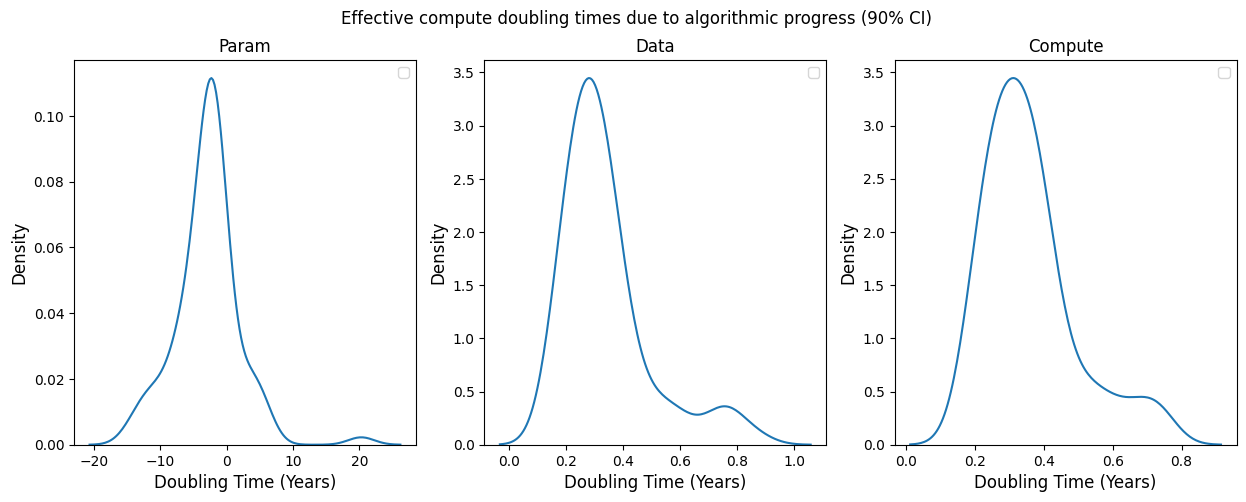

In [103]:
model_doubling_times = estimate_doubling_times(model_num, np.array(bootstrap_results)[:, 1:])

ci = 90
fig, ax = plt.subplots(1, 3, figsize=(15,5))
estimate_doubling_times(model_num, bootstrap_results)
doubling_times_plot(model_doubling_times[0], ci, ax[0], title="Param")
doubling_times_plot(model_doubling_times[1], ci, ax[1], title="Data")
doubling_times_plot(model_doubling_times[2], ci, ax[2], title="Compute")

fig.suptitle(f'Effective compute doubling times due to algorithmic progress ({ci}% CI)')

# filename = f"{date}_model_{model_num}_delta{delta}_doubling_times.pdf"
# plt.savefig(filename, bbox_inches='tight')
# files.download(filename)

plt.show()

In [104]:
ci = 95

print("Param")
print_stats(model_doubling_times[0], ci)
print("\n")

print("Data")
print_stats(model_doubling_times[1], ci)
print("\n")

print("Compute (months)")
print_stats(np.array(model_doubling_times[2]) * 12, ci)

Param
[-16.92679113  -2.45373011  73.4555695 ]


Data
[0.14431216 0.29867808 1.90918753]


Compute (months)
[ 1.83294551  4.11078439 10.91656838]


## Vocabulary sizes per benchmark

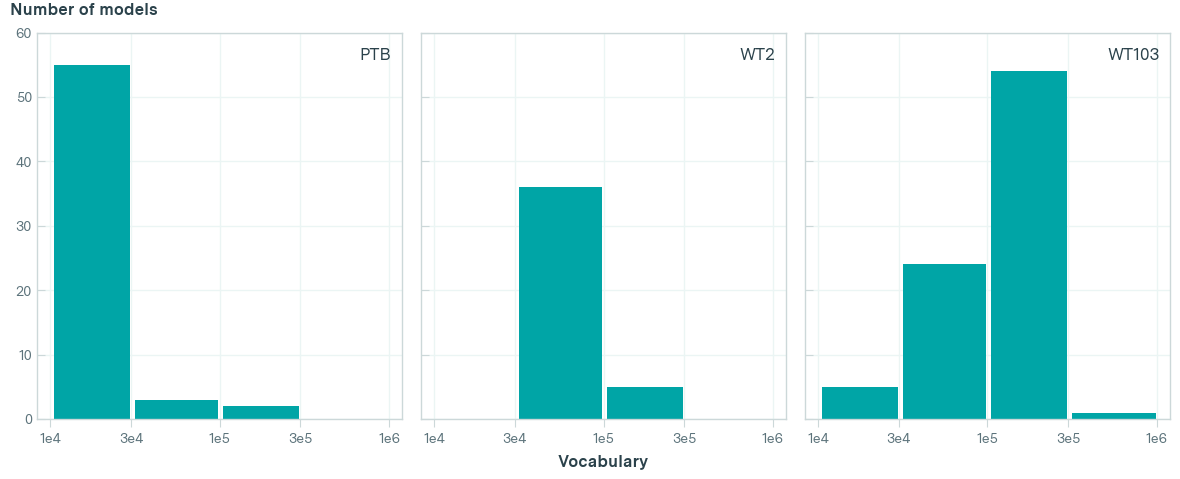

In [108]:
from matplotlib.ticker import FuncFormatter

df_main = df_head.copy(deep=True)
df_main["Vocabulary"].replace("?", np.nan, inplace=True)
df_main.dropna(subset=['Vocabulary'], inplace=True)
df_main["Vocabulary"] = pd.to_numeric(df_main["Vocabulary"])

with egraphs.epoch_theme():
    df_main = df_head.copy(deep=True)
    df_main["Vocabulary"].replace("?", np.nan, inplace=True)
    df_main.dropna(subset=['Vocabulary'], inplace=True)
    df_main["Vocabulary"] = pd.to_numeric(df_main["Vocabulary"])

    fig, ax = plt.subplots(1, 3, figsize=egraphs.px_to_in((880, 361)), sharey=True)
    #plt.subplots_adjust(wspace=0.05)

    xticks = [1e4, 3e4, 1e5, 3e5, 1e6]
    # xticks = [1e4, 2e4, 5e4, 1e5, 2e5, 5e5, 1e6]
    bins = [0] + xticks

    def format_tick(x, pos):
        if x == 0:
            return "0"
        base = int(x / (10 ** int(np.log10(x))))
        exponent = int(np.log10(x))
        return f"{base}e{exponent}"

    formatter = FuncFormatter(format_tick)

    for a in ax:
        a.set_xscale("log")
        a.set_xticks(xticks)
        a.xaxis.set_major_formatter(formatter)
        a.set_ylim(0, 60)
        a.set_xlim(xticks[0]/1.2, xticks[-1]*1.2)
        a.tick_params(axis='both', which='major')
        a.minorticks_off()

    rwidth = 0.95
    color = '#00A5A6'

    data = [
        (df_main[df_main["ptb_dummy"] == 1], 'PTB'),
        (df_main[df_main["wt2_dummy"] == 1], 'WT2'),
        (df_main[(df_main["ptb_dummy"] == 0) & (df_main["wt2_dummy"] == 0)], 'WT103')
    ]

    for i, d in enumerate(data):
        ax[i].hist(d[0]["Vocabulary"], bins=bins, rwidth=rwidth, color=color)
        ax[i].annotate(d[1], xy=(0.97, 0.96), xycoords="axes fraction", ha="right", va="top", fontsize=12)

    ax[0].set_ylabel("Number of models")
    ax[1].set_xlabel("Vocabulary")

    egraphs.relayout()

    plt.gcf().subplots_adjust(left=egraphs.px_to_x_fraction(15), right=1-egraphs.px_to_x_fraction(8))


#plt.savefig("vocabulary.pdf")
plt.show()

# Quantifying training data (Appendix F)

In [109]:
df_epoch = df1.copy(deep=True)

# Remove rows where 'epoch' is 'UNK' or NaN
df_epoch = df_epoch[df_epoch['epoch'] != 'UNK']
df_epoch = df_epoch.dropna(subset=['epoch'])

# Convert 'epoch' to numeric (if it's not already)
df_epoch['epoch'] = pd.to_numeric(df_epoch['epoch'])
df_epoch["tokens_seen"] = df_epoch["dataset"] * df_epoch["epoch"]

def effective_epochs(num_epochs, rd_prime=2.9157):
  """
  estimate of "effective data" based on https://arxiv.org/pdf/2305.16264.pdf
  2.9157 from table 1, only decay D
  """
  return 1 + rd_prime * (1 - np.exp(-num_epochs / rd_prime))

df_epoch["effective_data"] = df_epoch["dataset"] * effective_epochs(df_epoch["epoch"])

KeyError: 'epoch'

In [110]:
# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(df_epoch['publication_date'], df_epoch['epoch'])
plt.ylabel('Number of epochs')
plt.xlabel('Publication Date')
plt.title('Epochs vs Publication Date')

filename = f"{date}_epochs.pdf"
# plt.savefig(filename, bbox_inches='tight')

plt.show()

KeyError: 'epoch'

<Figure size 1000x600 with 0 Axes>

In [111]:
model_name_str = "model_7"
delta = 0.0025
model_num = int(re.search("\d+", model_name_str)[0])
model_name = globals()[model_name_str]

print(f"Current setup: model number {model_num}, regularization strength delta = {delta}")

Current setup: model number 7, regularization strength delta = 0.0025


## Tokens seen

In [112]:
np.random.seed(0)

num_params = num_params_in_model(model_num)
p0 = np.zeros(num_params)

df_epoch['ptb_dummy'] = (df_epoch['dataset_name'] == 'ptb').astype(int)
df_epoch['wt2_dummy'] = (df_epoch['dataset_name'] == 'wt2').astype(int)
df_epoch['transformer'] = df_epoch['Architecture'].apply(lambda x: 1 if x == 'Transformer' else 0).astype(int)

year = df_epoch["publication_date"]
param = df_epoch["param"]
dataset = df_epoch["tokens_seen"]
log_ppl = df_epoch["log_ppl"]
ptb_dummy = df_epoch['ptb_dummy']
wt2_dummy = df_epoch['wt2_dummy']
wt2_dummy = df_epoch['wt2_dummy']
transformer_dummy = df_epoch['transformer']

param_const = np.min(param)
dataset_const = np.min(dataset)
year_const = np.min(year)

res = minimize(residuals, p0, args=(model_name, year, param, dataset, ptb_dummy, wt2_dummy, log_ppl, delta, transformer_dummy), method='SLSQP')
print(res)

print("\n")
params_optimized = pd.Series(res.x, index=PARAMS_MAPPING[model_num])
print("Optimized parameters:")
print(params_optimized)

KeyError: 'dataset_name'

In [122]:
delta = 0.001
filename_suffix = f'_tokens_seen_delta{delta}_bootstrap_results.json'
latest_cached_filename = safe_max([f for f in os.listdir() if f.endswith(filename_suffix)])

In [125]:
if not (use_cached_bootstraps and latest_cached_filename):
  np.random.seed(0)
  n_bootstrap_samples = 100

  bootstrap_results = []
  for i in range(n_bootstrap_samples):
      bootstrap_indices = np.random.choice(np.array(log_ppl.index), size=len(log_ppl), replace=True)

      if model_num == 13:
        bootstrap_res = minimize(residuals, p0, args=(model_name, year[bootstrap_indices], param[bootstrap_indices],
                                                      dataset[bootstrap_indices], ptb_dummy[bootstrap_indices],
                                                      wt2_dummy[bootstrap_indices], log_ppl[bootstrap_indices], delta,
                                                      transformer_dummy[bootstrap_indices]), method='L-BFGS-B')
      else:
        bootstrap_res = minimize(residuals, p0, args=(model_name, year[bootstrap_indices], param[bootstrap_indices],
                                                      dataset[bootstrap_indices], ptb_dummy[bootstrap_indices],
                                                      wt2_dummy[bootstrap_indices], log_ppl[bootstrap_indices], delta), method='SLSQP')
      bootstrap_results.append(bootstrap_res.x)

      if i % 5 == 4:
          print(f"Bootstrap steps complete: ({i+1}/{n_bootstrap_samples})")


  confidence_intervals = np.percentile(bootstrap_results, [2.5, 97.5], axis=0)
  standard_errors = np.std(bootstrap_results, axis=0)

  print("Optimized parameters with confidence intervals and standard errors:")
  for i, name in enumerate(PARAMS_MAPPING[model_num]):
      print(f"{name}_opt: {params_optimized[i]}  CI: {confidence_intervals[:, i]}  SE: {standard_errors[i]}")

In [126]:
if use_cached_bootstraps and latest_cached_filename:
      with open(latest_cached_filename, 'r') as f:
            bootstrap_results = json.load(f)
else:
      bootstrap_results_to_save = [param_estimates.tolist() if isinstance(param_estimates, np.ndarray) else param_estimates for param_estimates in bootstrap_results]

      with open(f"{date}_tokens_seen_delta{delta}_bootstrap_results.json", 'w') as f:
            json.dump(bootstrap_results_to_save, f)

      files.download(f"{date}_tokens_seen_delta{delta}_bootstrap_results.json")

In [127]:
custom_filename_to_load = None
#custom_filename_to_load = '2024-01-12_tokens_seen_delta0.001_bootstrap_results.json'
if custom_filename_to_load:
    with open(filename, 'r') as f:
        bootstrap_results = json.load(f)
    bootstrap_results = np.array(bootstrap_results)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


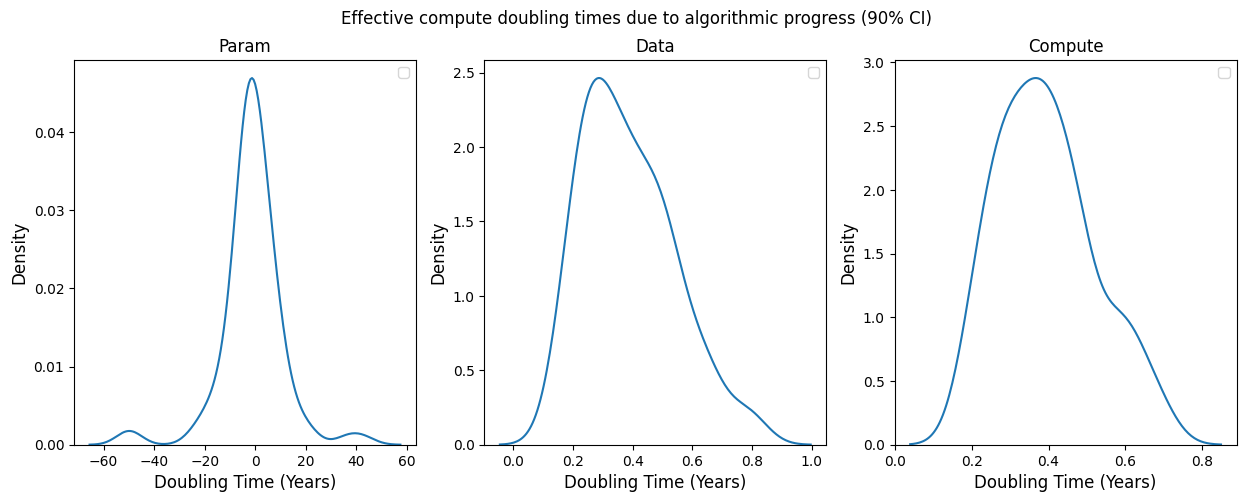

In [128]:
model_doubling_times = estimate_doubling_times(model_num, bootstrap_results)

ci = 90
fig, ax = plt.subplots(1, 3, figsize=(15,5))
estimate_doubling_times(model_num, bootstrap_results)
doubling_times_plot(model_doubling_times[0], ci, ax[0], title="Param")
doubling_times_plot(model_doubling_times[1], ci, ax[1], title="Data")
doubling_times_plot(model_doubling_times[2], ci, ax[2], title="Compute")

fig.suptitle(f'Effective compute doubling times due to algorithmic progress ({ci}% CI)')

filename = f"{date}_model_{model_num}_delta{delta}_doubling_times.pdf"
plt.savefig(filename, bbox_inches='tight')
# files.download(filename)

plt.show()

In [129]:
ci = 95

print("Param")
print_stats(model_doubling_times[0], ci)
print("\n")

print("Data")
print_stats(model_doubling_times[1], ci)
print("\n")

print("Compute (months)")
print_stats(np.array(model_doubling_times[2]) * 12, ci)

Param
[-103.73810163   -1.28712848   52.2464299 ]


Data
[0.13493336 0.36691769 1.28948825]


Compute (months)
[1.78243938 4.56479438 9.84988978]


## Tokens seen + impute epochs

In [130]:
df_main = df_head.copy(deep=True)

np.random.seed(0)

num_params = num_params_in_model(model_num)
p0 = np.zeros(num_params)
epoch_num = 1 # impute this number of epochs is NaN

df_main['ptb_dummy'] = (df_main['dataset_name'] == 'ptb').astype(int)
df_main['wt2_dummy'] = (df_main['dataset_name'] == 'wt2').astype(int)
df_main['transformer'] = df_main['Architecture'].apply(lambda x: 1 if x == 'Transformer' else 0).astype(int)
df_main['epoch'] = pd.to_numeric(df_main['epoch'], errors='coerce')
df_main['epoch'].fillna(epoch_num, inplace=True)

year = df_main["publication_date"]
param = df_main["param"]
dataset = df_main["dataset"] * df_main["epoch"]
log_ppl = df_main["log_ppl"]
ptb_dummy = df_main['ptb_dummy']
wt2_dummy = df_main['wt2_dummy']
transformer_dummy = df_main['transformer']

param_const = np.min(param)
dataset_const = np.min(dataset)
year_const = np.min(year)

res = minimize(residuals, p0, args=(model_name, year, param, dataset, ptb_dummy, wt2_dummy, log_ppl, delta, transformer_dummy), method='SLSQP')

print(res)

print("\n")
params_optimized = pd.Series(res.x, index=PARAMS_MAPPING[model_num])
print("Optimized parameters:")
print(params_optimized)

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.05533621614974888
       x: [ 6.240e-01  1.361e-01  2.182e-01 -2.627e-02  1.110e-01
            1.058e+00  8.206e-02 -2.327e-02  5.320e-02  1.434e-02]
     nit: 45
     jac: [ 1.283e-03  7.598e-04  3.971e-04 -9.037e-03 -3.397e-03
            1.930e-03  1.139e-03  9.473e-04 -1.177e-02 -8.900e-03]
    nfev: 519
    njev: 45


Optimized parameters:
alpha_const        0.623992
alpha_const_ptb    0.136143
alpha_const_wt2    0.218235
alpha_year        -0.026270
alpha_param        0.111019
beta_const         1.057794
beta_const_ptb     0.082064
beta_const_wt2    -0.023275
beta_year          0.053199
beta_data          0.014342
dtype: float64


In [131]:
np.random.seed(0)
n_bootstrap_samples = 100

bootstrap_results = []
for i in range(n_bootstrap_samples):
    bootstrap_indices = np.random.choice(np.array(log_ppl.index), size=len(log_ppl), replace=True)

    if model_num in {13, 17}:
      bootstrap_res = minimize(residuals, p0, args=(model_name, year[bootstrap_indices], param[bootstrap_indices],
                                                    dataset[bootstrap_indices], ptb_dummy[bootstrap_indices],
                                                    wt2_dummy[bootstrap_indices], log_ppl[bootstrap_indices], delta,
                                                    transformer_dummy[bootstrap_indices]), method='SLSQP')
    else:
      bootstrap_res = minimize(residuals, p0, args=(model_name, year[bootstrap_indices], param[bootstrap_indices],
                                                    dataset[bootstrap_indices], ptb_dummy[bootstrap_indices],
                                                    wt2_dummy[bootstrap_indices], log_ppl[bootstrap_indices], delta), method='SLSQP')
    bootstrap_results.append(bootstrap_res.x)

    if i % 5 == 4:
        print(f"Bootstrap steps complete: ({i+1}/{n_bootstrap_samples})")


confidence_intervals = np.percentile(bootstrap_results, [2.5, 97.5], axis=0)
standard_errors = np.std(bootstrap_results, axis=0)

print("Optimized parameters with confidence intervals and standard errors:")
for i, name in enumerate(PARAMS_MAPPING[model_num]):
    print(f"{name}_opt: {params_optimized[i]}  CI: {confidence_intervals[:, i]}  SE: {standard_errors[i]}")

Bootstrap steps complete: (5/100)
Bootstrap steps complete: (10/100)
Bootstrap steps complete: (15/100)
Bootstrap steps complete: (20/100)
Bootstrap steps complete: (25/100)
Bootstrap steps complete: (30/100)
Bootstrap steps complete: (35/100)
Bootstrap steps complete: (40/100)
Bootstrap steps complete: (45/100)
Bootstrap steps complete: (50/100)
Bootstrap steps complete: (55/100)
Bootstrap steps complete: (60/100)
Bootstrap steps complete: (65/100)
Bootstrap steps complete: (70/100)
Bootstrap steps complete: (75/100)
Bootstrap steps complete: (80/100)
Bootstrap steps complete: (85/100)
Bootstrap steps complete: (90/100)
Bootstrap steps complete: (95/100)
Bootstrap steps complete: (100/100)
Optimized parameters with confidence intervals and standard errors:
alpha_const_opt: 0.6239917032674905  CI: [0.0658074  1.31807986]  SE: 0.3578847168956489
alpha_const_ptb_opt: 0.13614317765299605  CI: [-0.37486875  0.34476478]  SE: 0.1978156489803002
alpha_const_wt2_opt: 0.218234815922595  CI: [-0

In [132]:
ci = 95

print("Param")
print_stats(model_doubling_times[0], ci)
print("\n")

print("Data")
print_stats(model_doubling_times[1], ci)
print("\n")

print("Compute (months)")
print_stats(np.array(model_doubling_times[2]) * 12, ci)

Param
[-103.73810163   -1.28712848   52.2464299 ]


Data
[0.13493336 0.36691769 1.28948825]


Compute (months)
[1.78243938 4.56479438 9.84988978]


## Tokens seen with diminishing returns

In [135]:
np.random.seed(0)

num_params = num_params_in_model(model_num)
p0 = np.zeros(num_params)

df_epoch['ptb_dummy'] = (df_epoch['dataset_name'] == 'ptb').astype(int)
df_epoch['wt2_dummy'] = (df_epoch['dataset_name'] == 'wt2').astype(int)
df_epoch['transformer'] = df_epoch['Architecture'].apply(lambda x: 1 if x == 'Transformer' else 0).astype(int)

year = df_epoch["publication_date"]
param = df_epoch["param"]
dataset = df_epoch["effective_data"]
log_ppl = df_epoch["log_ppl"]
ptb_dummy = df_epoch['ptb_dummy']
wt2_dummy = df_epoch['wt2_dummy']
wt2_dummy = df_epoch['wt2_dummy']
transformer_dummy = df_epoch['transformer']

param_const = np.min(param)
dataset_const = np.min(dataset)
year_const = np.min(year)

res = minimize(residuals, p0, args=(model_name, year, param, dataset, ptb_dummy, wt2_dummy, log_ppl, delta, transformer_dummy), method='SLSQP')
print(res)

print("\n")
params_optimized = pd.Series(res.x, index=PARAMS_MAPPING[model_num])
print("Optimized parameters:")
print(params_optimized)

KeyError: 'dataset_name'

In [136]:
delta = 0.001
filename_suffix = f'_effective_data_delta{delta}_bootstrap_results.json'
latest_cached_filename = safe_max([f for f in os.listdir() if f.endswith(filename_suffix)])

In [137]:
if not (use_cached_bootstraps and latest_cached_filename):
  np.random.seed(0)
  n_bootstrap_samples = 100

  bootstrap_results = []
  for i in range(n_bootstrap_samples):
      bootstrap_indices = np.random.choice(np.array(log_ppl.index), size=len(log_ppl), replace=True)

      if model_num == 13:
        bootstrap_res = minimize(residuals, p0, args=(model_name, year[bootstrap_indices], param[bootstrap_indices],
                                                      dataset[bootstrap_indices], ptb_dummy[bootstrap_indices],
                                                      wt2_dummy[bootstrap_indices], log_ppl[bootstrap_indices], delta,
                                                      transformer_dummy[bootstrap_indices]), method='SLSQP')
      else:
        bootstrap_res = minimize(residuals, p0, args=(model_name, year[bootstrap_indices], param[bootstrap_indices],
                                                      dataset[bootstrap_indices], ptb_dummy[bootstrap_indices],
                                                      wt2_dummy[bootstrap_indices], log_ppl[bootstrap_indices], delta), method='SLSQP')
      bootstrap_results.append(bootstrap_res.x)

      if i % 5 == 4:
          print(f"Bootstrap steps complete: ({i+1}/{n_bootstrap_samples})")


  confidence_intervals = np.percentile(bootstrap_results, [2.5, 97.5], axis=0)
  standard_errors = np.std(bootstrap_results, axis=0)

  print("Optimized parameters with confidence intervals and standard errors:")
  for i, name in enumerate(PARAMS_MAPPING[model_num]):
      print(f"{name}_opt: {params_optimized[i]}  CI: {confidence_intervals[:, i]}  SE: {standard_errors[i]}")

Bootstrap steps complete: (5/100)
Bootstrap steps complete: (10/100)
Bootstrap steps complete: (15/100)
Bootstrap steps complete: (20/100)
Bootstrap steps complete: (25/100)
Bootstrap steps complete: (30/100)
Bootstrap steps complete: (35/100)
Bootstrap steps complete: (40/100)
Bootstrap steps complete: (45/100)
Bootstrap steps complete: (50/100)
Bootstrap steps complete: (55/100)
Bootstrap steps complete: (60/100)
Bootstrap steps complete: (65/100)
Bootstrap steps complete: (70/100)
Bootstrap steps complete: (75/100)
Bootstrap steps complete: (80/100)
Bootstrap steps complete: (85/100)
Bootstrap steps complete: (90/100)
Bootstrap steps complete: (95/100)
Bootstrap steps complete: (100/100)
Optimized parameters with confidence intervals and standard errors:
alpha_const_opt: 0.6239917032674905  CI: [0.0658074  1.31807986]  SE: 0.3578847168956489
alpha_const_ptb_opt: 0.13614317765299605  CI: [-0.37486875  0.34476478]  SE: 0.1978156489803002
alpha_const_wt2_opt: 0.218234815922595  CI: [-0

In [138]:
if use_cached_bootstraps and latest_cached_filename:
      with open(latest_cached_filename, 'r') as f:
            bootstrap_results = json.load(f)
else:
      bootstrap_results_to_save = [param_estimates.tolist() if isinstance(param_estimates, np.ndarray) else param_estimates for param_estimates in bootstrap_results]

      with open(f"{date}_effective_data_delta{delta}_bootstrap_results.json", 'w') as f:
            json.dump(bootstrap_results_to_save, f)

      files.download(f"{date}_effective_data_delta{delta}_bootstrap_results.json")

In [139]:
custom_filename_to_load = None
#custom_filename = '2024-01-12_effective_data_delta0.001_bootstrap_results.json'
if custom_filename_to_load:
    with open(filename, 'r') as f:
        bootstrap_results = json.load(f)
    bootstrap_results = np.array(bootstrap_results)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


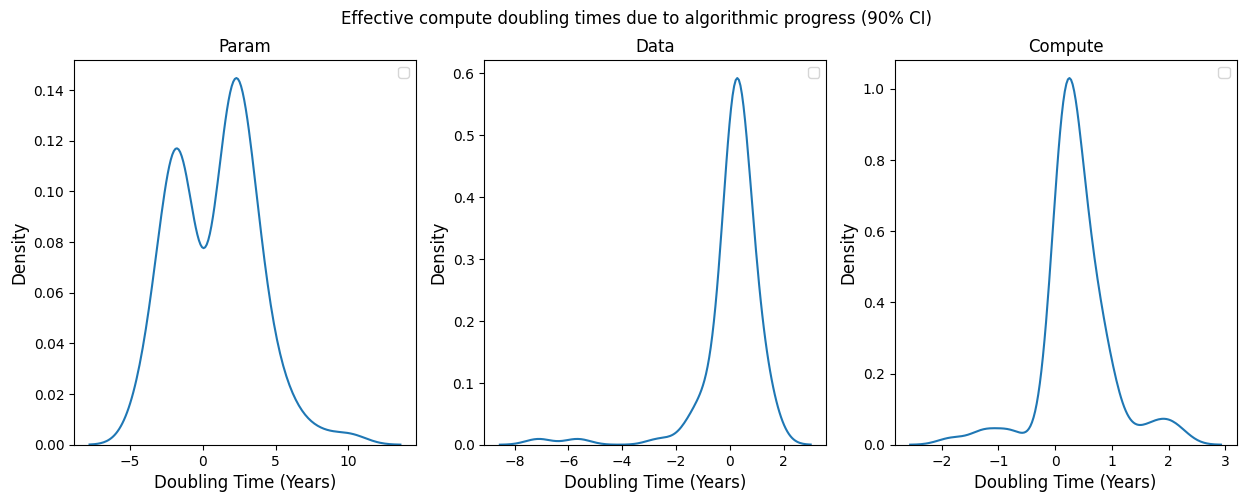

In [140]:
model_doubling_times = estimate_doubling_times(model_num, bootstrap_results)

ci = 90
fig, ax = plt.subplots(1, 3, figsize=(15,5))
estimate_doubling_times(model_num, bootstrap_results)
doubling_times_plot(model_doubling_times[0], ci, ax[0], title="Param")
doubling_times_plot(model_doubling_times[1], ci, ax[1], title="Data")
doubling_times_plot(model_doubling_times[2], ci, ax[2], title="Compute")

fig.suptitle(f'Effective compute doubling times due to algorithmic progress ({ci}% CI)')

filename = f"{date}_model_{model_num}_delta{delta}_doubling_times.pdf"
plt.savefig(filename, bbox_inches='tight')
# files.download(filename)

plt.show()

In [141]:
ci = 95

print("Param")
print_stats(model_doubling_times[0], ci)
print("\n")

print("Data")
print_stats(model_doubling_times[1], ci)
print("\n")

print("Compute (months)")
print_stats(np.array(model_doubling_times[2]) * 12, ci)

Param
[-5.84566489  1.7088767  13.41260665]


Data
[-11.05780632   0.18565692   3.48967977]


Compute (months)
[-60.7970335    3.07023546  30.09264305]


## Tokens seen with diminishing returns + impute epochs

In [142]:
df_main = df_head.copy(deep=True)

np.random.seed(0)

num_params = num_params_in_model(model_num)
p0 = np.zeros(num_params)
epoch_num = 1 # impute this number of epochs is NaN

df_main['ptb_dummy'] = (df_main['dataset_name'] == 'ptb').astype(int)
df_main['wt2_dummy'] = (df_main['dataset_name'] == 'wt2').astype(int)
df_main['transformer'] = df_main['Architecture'].apply(lambda x: 1 if x == 'Transformer' else 0).astype(int)
df_main['epoch'] = pd.to_numeric(df_main['epoch'], errors='coerce')
df_main['epoch'].fillna(epoch_num, inplace=True)

def effective_epochs(num_epochs, rd_prime=2.9157):
  """
  estimate of "effective data" based on https://arxiv.org/pdf/2305.16264.pdf
  2.9157 from table 1, only decay D
  """
  return 1 + rd_prime * (1 - np.exp(-num_epochs / rd_prime))

year = df_main["publication_date"]
param = df_main["param"]
dataset = df_main["dataset"] * effective_epochs(df_main["epoch"])
log_ppl = df_main["log_ppl"]
ptb_dummy = df_main['ptb_dummy']
wt2_dummy = df_main['wt2_dummy']
transformer_dummy = df_main['transformer']

param_const = np.min(param)
dataset_const = np.min(dataset)
year_const = np.min(year)

res = minimize(residuals, p0, args=(model_name, year, param, dataset, ptb_dummy, wt2_dummy, log_ppl, delta, transformer_dummy), method='SLSQP')

print(res)

print("\n")
params_optimized = pd.Series(res.x, index=PARAMS_MAPPING[model_num])
print("Optimized parameters:")
print(params_optimized)

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.04893085677762427
       x: [ 9.865e-01 -1.856e-02  1.414e-01  1.680e-02  7.029e-02
            7.090e-01  1.941e-01 -1.204e-02  2.089e-02  3.772e-02]
     nit: 29
     jac: [ 7.547e-04  2.858e-04 -5.748e-04 -3.271e-03 -1.287e-03
            2.710e-05  6.063e-05 -4.077e-04  1.131e-03 -1.306e-03]
    nfev: 331
    njev: 29


Optimized parameters:
alpha_const        0.986493
alpha_const_ptb   -0.018555
alpha_const_wt2    0.141435
alpha_year         0.016799
alpha_param        0.070295
beta_const         0.708953
beta_const_ptb     0.194133
beta_const_wt2    -0.012038
beta_year          0.020889
beta_data          0.037720
dtype: float64


In [143]:
df_main['predicted_log_ppl'] = model_name(res.x, year, param, dataset, ptb_dummy, wt2_dummy)
r2_score_value = r2_score(df_main["log_ppl"], df_main['predicted_log_ppl'])

fig = px.scatter(df_main, x='predicted_log_ppl', y=df_main["log_ppl"], hover_data=['system'], trendline='ols')

fig.add_annotation(
        x=0.50,
        y=0.95,
        xref="paper",
        yref="paper",
        text=f"r2 total = {r2_score_value:.2f}",
        showarrow=False,
)

fig.update_layout(title="Nonlinear model: actual vs predicted cross entropy",
    xaxis_title="Predicted Log PPL",
    yaxis_title="Actual Log PPL")

fig.show()

In [144]:
np.random.seed(0)
n_bootstrap_samples = 100

bootstrap_results = []
for i in range(n_bootstrap_samples):
    bootstrap_indices = np.random.choice(np.array(log_ppl.index), size=len(log_ppl), replace=True)

    if model_num in {13, 17}:
      bootstrap_res = minimize(residuals, p0, args=(model_name, year[bootstrap_indices], param[bootstrap_indices],
                                                    dataset[bootstrap_indices], ptb_dummy[bootstrap_indices],
                                                    wt2_dummy[bootstrap_indices], log_ppl[bootstrap_indices], delta,
                                                    transformer_dummy[bootstrap_indices]), method='SLSQP')
    else:
      bootstrap_res = minimize(residuals, p0, args=(model_name, year[bootstrap_indices], param[bootstrap_indices],
                                                    dataset[bootstrap_indices], ptb_dummy[bootstrap_indices],
                                                    wt2_dummy[bootstrap_indices], log_ppl[bootstrap_indices], delta), method='SLSQP')
    bootstrap_results.append(bootstrap_res.x)

    if i % 5 == 4:
        print(f"Bootstrap steps complete: ({i+1}/{n_bootstrap_samples})")


confidence_intervals = np.percentile(bootstrap_results, [2.5, 97.5], axis=0)
standard_errors = np.std(bootstrap_results, axis=0)

print("Optimized parameters with confidence intervals and standard errors:")
for i, name in enumerate(PARAMS_MAPPING[model_num]):
    print(f"{name}_opt: {params_optimized[i]}  CI: {confidence_intervals[:, i]}  SE: {standard_errors[i]}")

Bootstrap steps complete: (5/100)
Bootstrap steps complete: (10/100)
Bootstrap steps complete: (15/100)
Bootstrap steps complete: (20/100)
Bootstrap steps complete: (25/100)
Bootstrap steps complete: (30/100)
Bootstrap steps complete: (35/100)
Bootstrap steps complete: (40/100)
Bootstrap steps complete: (45/100)
Bootstrap steps complete: (50/100)
Bootstrap steps complete: (55/100)
Bootstrap steps complete: (60/100)
Bootstrap steps complete: (65/100)
Bootstrap steps complete: (70/100)
Bootstrap steps complete: (75/100)
Bootstrap steps complete: (80/100)
Bootstrap steps complete: (85/100)
Bootstrap steps complete: (90/100)
Bootstrap steps complete: (95/100)
Bootstrap steps complete: (100/100)
Optimized parameters with confidence intervals and standard errors:
alpha_const_opt: 0.9864925573480439  CI: [-6.49608191e-04  1.25635571e+00]  SE: 0.3310236090665105
alpha_const_ptb_opt: -0.018555037136344703  CI: [-0.41345241  0.27590418]  SE: 0.18188070824102825
alpha_const_wt2_opt: 0.14143528721

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


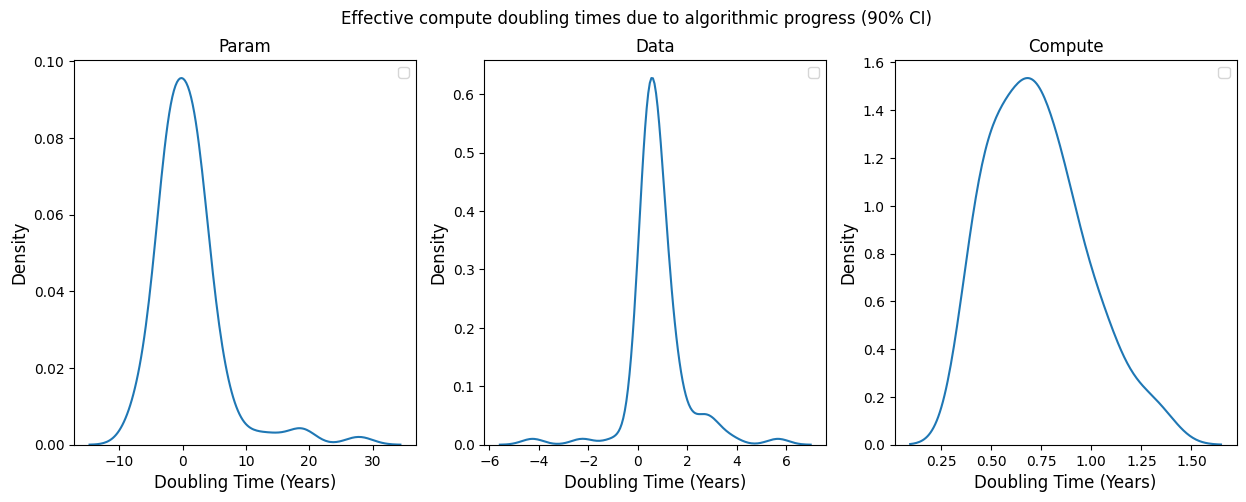

In [145]:
model_doubling_times = estimate_doubling_times(model_num, bootstrap_results)

ci = 90
fig, ax = plt.subplots(1, 3, figsize=(15,5))
estimate_doubling_times(model_num, bootstrap_results)
doubling_times_plot(model_doubling_times[0], ci, ax[0], title="Param")
doubling_times_plot(model_doubling_times[1], ci, ax[1], title="Data")
doubling_times_plot(model_doubling_times[2], ci, ax[2], title="Compute")

fig.suptitle(f'Effective compute doubling times due to algorithmic progress ({ci}% CI)')

filename = f"{date}_model_{model_num}_delta{delta}_doubling_times.pdf"
# plt.savefig(filename, bbox_inches='tight')
# files.download(filename)

plt.show()

In [146]:
ci = 95

print("Param")
print_stats(model_doubling_times[0], ci)
print("\n")

print("Data")
print_stats(model_doubling_times[1], ci)
print("\n")

print("Compute (months)")
print_stats(np.array(model_doubling_times[2]) * 12, ci)

Param
[-20.23057884   0.82307609  69.98348591]


Data
[-7.95554444  0.60195929 15.76775069]


Compute (months)
[ 4.29332562  8.56339651 18.84540117]


In [147]:
# doubling times using numerical "optimal scaling" approach
ci = 95
compute_doubling_times = [compute_doubling_numerical(param, model_num, 2023, compute=1e25) for param in bootstrap_results]

print("Compute (months)")
print_stats(np.array(compute_doubling_times) * 12, ci)

Compute (months)
[ 4.34072952  8.57789079 19.28699528]


# Irreducible loss (Appendix H)

In [148]:
df_ir = df_head.copy(deep=True)

param_names = ['gamma', 'gamma_ptb', 'gamma_wt2', \
               'alpha_const', 'alpha_const_ptb', 'alpha_const_wt2', 'alpha_year', 'alpha_param', \
               'beta_const', 'beta_const_ptb', 'beta_const_wt2', 'beta_year', 'beta_data'
               ]

np.random.seed(0)
p0 = np.zeros(len(param_names))
delta = 0.0025

year = df_ir["publication_date"]
param = df_ir["param"]
dataset = df_ir["dataset"]
log_ppl = df_ir["log_ppl"]
ptb_dummy = df_ir['ptb_dummy']
wt2_dummy = df_ir['wt2_dummy']

param_const = np.min(param)
dataset_const = np.min(dataset)
year_const = np.min(year)

def model_ir(params, year, param, dataset, category_ptb, category_wt2):
    # load latest param estimates, initially p0
    gamma, gamma_ptb, gamma_wt2, \
    alpha_const, alpha_const_ptb, alpha_const_wt2, alpha_year, alpha_param, \
    beta_const, beta_const_ptb, beta_const_wt2, beta_year, beta_data = params

    gamma_prime = prime(gamma, gamma_ptb, gamma_wt2, category_ptb, category_wt2)
    alpha_const_prime = prime(alpha_const, alpha_const_ptb, alpha_const_wt2, category_ptb, category_wt2)
    beta_const_prime = prime(beta_const, beta_const_ptb, beta_const_wt2, category_ptb, category_wt2)
    alpha_terms = (alpha_const_prime - alpha_year * (year - year_const) - alpha_param * log_diff(param, param_const))
    beta_terms = (beta_const_prime - beta_year * (year - year_const) - beta_data * log_diff(dataset, dataset_const))

    return gamma_prime + np.exp(alpha_terms) + np.exp(beta_terms)

def residuals_ir(params, year, param, dataset, category_ptb, category_wt2, log_ppl, delta):
    residuals = log_ppl - model_ir(params, year, param, dataset, category_ptb, category_wt2)
    l1_reg = delta * np.sum(np.abs(params))
    return np.mean(np.square(residuals)) + l1_reg

res = minimize(residuals_ir, p0, args=(year, param, dataset, ptb_dummy, wt2_dummy, log_ppl, delta), method='SLSQP')
print(res)

print("\n")
params_optimized = pd.Series(res.x, index=param_names)
print("Optimized parameters:")
print(params_optimized)

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.0517375747124533
       x: [-5.362e-05  1.051e-01 ...  3.249e-02  3.970e-02]
     nit: 45
     jac: [ 2.590e-03  4.942e-04 ... -4.575e-03 -2.104e-03]
    nfev: 652
    njev: 45


Optimized parameters:
gamma             -0.000054
gamma_ptb          0.105076
gamma_wt2         -0.043656
alpha_const        0.934120
alpha_const_ptb    0.000785
alpha_const_wt2    0.147471
alpha_year         0.008235
alpha_param        0.067760
beta_const         0.763463
beta_const_ptb     0.117748
beta_const_wt2     0.000643
beta_year          0.032490
beta_data          0.039699
dtype: float64


In [149]:
delta = 0.0025
filename = f"_model_ir_delta{delta}_bootstrap_results.json"
latest_cached_filename = safe_max([f for f in os.listdir() if f.endswith(filename_suffix)])

In [150]:
if not (use_cached_bootstraps and latest_cached_filename):
    np.random.seed(0)
    n_bootstrap_samples = 100

    bootstrap_results = []
    for i in range(n_bootstrap_samples):
        bootstrap_indices = np.random.choice(np.array(log_ppl.index), size=len(log_ppl), replace=True)

        bootstrap_res = minimize(residuals_ir, p0, args=(year[bootstrap_indices], param[bootstrap_indices],
                                                    dataset[bootstrap_indices], ptb_dummy[bootstrap_indices],
                                                    wt2_dummy[bootstrap_indices], log_ppl[bootstrap_indices], delta), method='SLSQP')
        bootstrap_results.append(bootstrap_res.x)

        if i % 5 == 4:
            print(f"Bootstrap steps complete: ({i+1}/{n_bootstrap_samples})")


    confidence_intervals = np.percentile(bootstrap_results, [2.5, 97.5], axis=0)
    standard_errors = np.std(bootstrap_results, axis=0)

    print("Optimized parameters with confidence intervals and standard errors:")
    for i, name in enumerate(param_names):
        print(f"{name}_opt: {params_optimized[i]}  CI: {confidence_intervals[:, i]}  SE: {standard_errors[i]}")

In [151]:
if use_cached_bootstraps and latest_cached_filename:
      with open(latest_cached_filename, 'r') as f:
            bootstrap_results = json.load(f)
else:
      bootstrap_results_to_save = [param_estimates.tolist() if isinstance(param_estimates, np.ndarray) else param_estimates for param_estimates in bootstrap_results]

      filename = f"{date}_model_ir_delta{delta}_bootstrap_results.json"
      with open(filename, 'w') as f:
            json.dump(bootstrap_results_to_save, f)
      files.download(filename)

In [152]:
custom_filename_to_load = None
#custom_filename_to_load = '2024-01-12_model_ir_delta0.0025_bootstrap_results.json'
if custom_filename_to_load:
    with open(filename, 'r') as f:
        bootstrap_results = json.load(f)
    bootstrap_results = np.array(bootstrap_results)

In [153]:
bootstrap_array = np.array(bootstrap_results).T
pred_params = {name: bootstrap_array[i] for i, name in enumerate(param_names)}

# Calculate doubling times
param_doubling = pred_params['alpha_param'] / pred_params['alpha_year'] * np.log(2)
data_doubling = pred_params['beta_data'] / pred_params['beta_year'] * np.log(2)
compute_doubling = (1/param_doubling + 1/data_doubling) ** (-1)

IndexError: index 10 is out of bounds for axis 0 with size 10

In [ ]:
ci = 90

fig, ax = plt.subplots(1, 3, figsize=(15,5))
doubling_times_plot(param_doubling, ci, ax[0], title="Param")
doubling_times_plot(data_doubling, ci, ax[1], title="Data")
doubling_times_plot(compute_doubling, ci, ax[2], title="Compute")

fig.suptitle(f'Effective compute doubling times due to algorithmic progress ({ci}% CI)')

filename = f"{date}_model_cluster_delta{delta}_doubling_times.pdf"
# plt.savefig(filename, bbox_inches='tight')
# files.download(filename)

plt.show()

In [ ]:
ci = 95

print("Param")
print_stats(param_doubling, ci)
print("\n")

print("Data")
print_stats(data_doubling, ci)
print("\n")

print("Compute")
print_stats(np.array(compute_doubling) * 12, ci)

# Clustering (Appendix I)

In [ ]:
df3 = df_cluster.copy(deep=True)

# get list of clusters and number of clusters
grouped = df3.groupby('cluster').apply(lambda x: x.index.tolist())
clusters = grouped.tolist()
num_clusters = len(clusters)

param_names = ['alpha_const', 'alpha_const_ptb', 'alpha_const_wt2', 'alpha_year', 'alpha_param', \
               'beta_const', 'beta_const_ptb', 'beta_const_wt2', 'beta_year', 'beta_data']

np.random.seed(0)
# p0 = np.zeros(len(param_names))
# delta = 0.0025

year = df3["publication_date"]
param = df3["param"]
dataset = df3["dataset"]
log_ppl = df3["log_ppl"]
ptb_dummy = df3['ptb_dummy']
wt2_dummy = df3['wt2_dummy']

param_const = np.min(param)
dataset_const = np.min(dataset)
year_const = np.min(year)

def model_cluster(params, year, param, dataset, category_ptb, category_wt2):
    # equivalent to model 7
    alpha_const, alpha_const_ptb, alpha_const_wt2, alpha_year, alpha_param, \
    beta_const, beta_const_ptb, beta_const_wt2, beta_year, beta_data = params

    alpha_const_prime = prime(alpha_const, alpha_const_ptb, alpha_const_wt2, category_ptb, category_wt2)
    beta_const_prime = prime(beta_const, beta_const_ptb, beta_const_wt2, category_ptb, category_wt2)
    alpha_terms = (alpha_const_prime - alpha_year * (year - year_const) - alpha_param * log_diff(param, param_const))
    beta_terms = (beta_const_prime - beta_year * (year - year_const) - beta_data * log_diff(dataset, dataset_const))

    return build_model(alpha_terms, beta_terms)

def sigmoid(x):
  return 1/(1 + np.exp(-x))

def correlation_matrix(rho):
  """
  - not in same cluster: 0
  - same cluster, not diagonal: rho
  - diagonal: 1
  """
  n = len(df3["cluster"])
  M = np.zeros((n, n))

  for i in range(n):
    for j in range(n):
      if i == j: # if diagonal
        M[i, j] = 1 # correlation with self
      elif df3["cluster"][i] == df3["cluster"][j]: # if same cluster
        M[i, j] = rho # correlation between observations in same cluster, to be estimated

  return M


def log_block_determinant(rho, n):
  """
  log of determinant of each block.
  using logs so we can add the determinants for each block,
  to get the overall log determinant for the whole correlation matrix
  """
  return n*np.log(1-rho) + np.log(1+rho*n)

def correlation_matrix_log_determinant(rho):
  """
  log determinant of full correlation matrix,
  which is itself block diagonal,
  where each block corresponds to the relevant clusters.
  to do this you need to ensure the observations are indexed correctly,
  which is done by default here
  """
  log_det = 0
  for i in range(num_clusters):
    cluster_size = len(clusters[i])
    log_det += log_block_determinant(rho, cluster_size-1)

  return log_det

def negative_log_likelihood(params):
    alpha_const, alpha_const_ptb, alpha_const_wt2, alpha_year, alpha_param, \
    beta_const, beta_const_ptb, beta_const_wt2, beta_year, beta_data, \
    sigma, rho = params
    sigma = np.exp(sigma)
    rho = sigmoid(rho)

    epsilon = log_ppl - model_cluster(params[:-2], year, param, dataset, ptb_dummy, wt2_dummy)

    n = len(epsilon)

    result = correlation_matrix_log_determinant(rho)/2 + n*np.log(sigma**2)/2

    for i in range(num_clusters):
      n = len(clusters[i])
      c = 1/rho + n/(1-rho)

      on_diagonal = 1/(1-rho) - 1/(c*(1-rho)**2)
      off_diagonal = -1/(c*(1-rho)**2)

      for j in clusters[i]:
        for k in clusters[i]:
          if j == k:
            result += on_diagonal*epsilon[j]*epsilon[k]/(2*sigma**2)
          else:
            result += off_diagonal*epsilon[j]*epsilon[k]/(2*sigma**2)

    return result

np.seterr(all="ignore")
res_cluster = minimize(negative_log_likelihood, x0=[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5], method="SLSQP")
print(res_cluster)

params_optimized = pd.Series(res_cluster.x[:-2], index=param_names)
sigma, rho = res_cluster.x[-2:]
sigma = np.exp(sigma)
rho = sigmoid(rho)

print("Optimized parameters:")
print(params_optimized)
print("sigma", sigma)
print("rho", rho)

In [ ]:
np.random.seed(0)
n_bootstrap_samples = 100

# Perform bootstrap sampling and optimization
bootstrap_results = []
for i in range(n_bootstrap_samples):
    bootstrap_indices = np.random.choice(np.array(log_ppl.index), size=len(log_ppl), replace=True)

    df3_bootstrap = df3.iloc[bootstrap_indices]
    df3_bootstrap.reset_index(inplace=True)

    year = df3_bootstrap["publication_date"]
    param = df3_bootstrap["param"]
    dataset = df3_bootstrap["dataset"]
    log_ppl = df3_bootstrap["log_ppl"]
    dataset_ptb = df3_bootstrap['ptb_dummy']
    dataset_wt2 = df3_bootstrap['wt2_dummy']

    param_const = np.min(param)
    dataset_const = np.min(dataset)

    grouped = df3_bootstrap.groupby('cluster').apply(lambda x: x.index.tolist())
    clusters = grouped.tolist()
    num_clusters = len(clusters)

    def negative_log_likelihood(params):
      alpha_const, alpha_const_ptb, alpha_const_wt2, alpha_year, alpha_param, \
        beta_const, beta_const_ptb, beta_const_wt2, beta_year, beta_data,\
        sigma, rho = params
      sigma = np.exp(sigma)
      rho = sigmoid(rho)

      epsilon = log_ppl - model_cluster(params[:-2], year, param, dataset, dataset_ptb, dataset_wt2)

      n = len(epsilon)

      result = correlation_matrix_log_determinant(rho)/2 + n*np.log(sigma**2)/2

      for i in range(num_clusters):
        n = len(clusters[i])
        c = 1/rho + n/(1-rho)

        on_diagonal = 1/(1-rho) - 1/(c*(1-rho)**2)
        off_diagonal = -1/(c*(1-rho)**2)

        for j in clusters[i]:
          for k in clusters[i]:
            if j == k:
              result += on_diagonal*epsilon[j]*epsilon[k]/(2*sigma**2)
            else:
              result += off_diagonal*epsilon[j]*epsilon[k]/(2*sigma**2)

      return result

    bootstrap_res_cluster = minimize(negative_log_likelihood, x0=[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5], method="SLSQP")
    bootstrap_results.append(bootstrap_res_cluster.x)

    if i % 5 == 4:
      print("Bootstrap steps complete: (%d/%d)" % (i+1, n_bootstrap_samples))

# Calculate confidence intervals
confidence_intervals = np.percentile(bootstrap_results, [2.5, 97.5], axis=0)
standard_errors = np.std(bootstrap_results, axis=0)

print("Optimized parameters with confidence intervals and standard errors:")
for i, name in enumerate(param_names):
    print(f"{name}_opt: {params_optimized[i]}  CI: {confidence_intervals[:, i]}  SE: {standard_errors[i]}")

In [ ]:
bootstrap_results_to_save = [param_estimates.tolist() if isinstance(param_estimates, np.ndarray) else param_estimates for param_estimates in bootstrap_results]

with open(f"{date}_model_cluster_bootstrap_results.json", 'w') as f:
      json.dump(bootstrap_results_to_save, f)

files.download(f"{date}_model_cluster_bootstrap_results.json")

In [ ]:
filename = '2024-01-12_model_cluster_bootstrap_results.json'
with open(filename, 'r') as f:
    bootstrap_results = json.load(f)
bootstrap_results = np.array(bootstrap_results)

In [ ]:
bootstrap_array = np.array(bootstrap_results).T
pred_params = {name: bootstrap_array[i] for i, name in enumerate(param_names)}

# Calculate doubling times
param_doubling = pred_params['alpha_param'] / pred_params['alpha_year'] * np.log(2)
data_doubling = pred_params['beta_data'] / pred_params['beta_year'] * np.log(2)
compute_doubling = (1/param_doubling + 1/data_doubling) ** (-1)

In [ ]:
ci = 90

fig, ax = plt.subplots(1, 3, figsize=(15,5))
doubling_times_plot(param_doubling, ci, ax[0], title="Param")
doubling_times_plot(data_doubling, ci, ax[1], title="Data")
doubling_times_plot(compute_doubling, ci, ax[2], title="Compute")

fig.suptitle(f'Effective compute doubling times due to algorithmic progress ({ci}% CI)')

filename = f"{date}_model_cluster_delta{delta}_doubling_times.pdf"
# plt.savefig(filename, bbox_inches='tight')
# files.download(filename)

plt.show()

In [ ]:
ci = 95

print("Param")
print_stats(param_doubling, ci)
print("\n")

print("Data")
print_stats(data_doubling, ci)
print("\n")

print("Compute")
print_stats(np.array(compute_doubling) * 12, ci)

# Compute-only model graphs (Appendix J.1)

## Tokens per parameter over time

In [154]:
models = {"Gopher": ["2021/12/08", 2.80E+11, 3.00E+11],
          "Chinchilla": ["2022/03/29", 7.00E+10, 1.40E+12],
          "GPT-3": ["2020/05/28", 1.75E+11, 4.99E+11]}

for model in models:
    models[model][0] = mdates.date2num(pd.to_datetime(models[model][0])) / 365.242199 + 1970

print(models)

{'Gopher': [2021.9354008160487, 280000000000.0, 300000000000.0], 'Chinchilla': [2022.2393087442779, 70000000000.0, 1400000000000.0], 'GPT-3': [2020.4049095378489, 175000000000.0, 499000000000.0]}


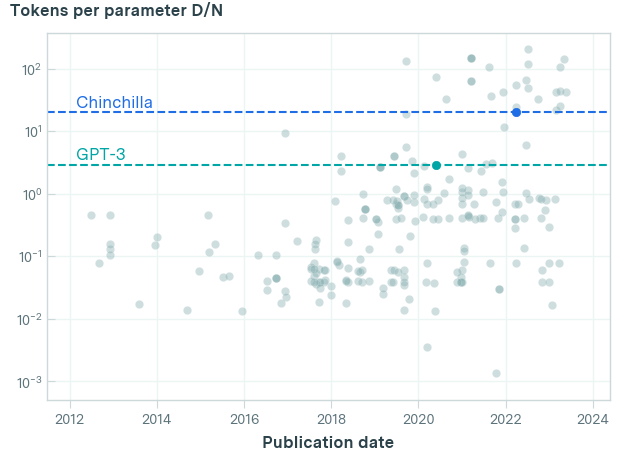

In [156]:
with egraphs.epoch_theme():
    df_main = df_head.copy(deep=True)
    df_main["ratios"] = df_main["dataset"] / df_main["param"]
    min_year, max_year = np.min(df_main["publication_date"]), np.max(df_main["publication_date"])
    x = np.linspace(min_year, max_year, 100)

    plt.scatter(df_main["publication_date"], df_main["ratios"], color='#85ADAF66', edgecolor='#FFFFFF33')

    for model_name, color in zip(["GPT-3", "Chinchilla"], ["#00A5A6", "#1F6EE5"]):
        date = models[model_name][0]
        ratio =  models[model_name][2] / models[model_name][1]
        opt = np.ones(100) * ratio
        plt.axhline(y=ratio, linestyle='dashed', color=color)
        plt.scatter(date, ratio, color=color)
        plt.text(np.floor(min_year) + 0.15, ratio * 1.1, f"{model_name}", verticalalignment='bottom', color=color, fontsize=12)

    # for model in models:
    #   x = models[model]
    #   date = x[0]
    #   ratio = x[1] / x[2]
    #   plt.scatter(date, ratio, color='black')
    #   plt.text(date - 0.5, ratio * 1.5, f" {model}", verticalalignment='bottom', color="black", fontsize=12, backgroundcolor="white")

    plt.xlabel("Publication date")
    #plt.ylabel(r"Tokens per parameter $D/N$")
    plt.ylabel(r"Tokens per parameter D/N")
    plt.yscale("log")

    plt.xlim(min_year - 1, max_year + 1)
    plt.ylim(bottom=0.5 * 1e-3)

    plt.minorticks_off()

    egraphs.relayout()

    plt.savefig("dn_ratio.pdf")
    plt.show()

## Comparison of scaling behavior (Chinchilla vs Compute-only model)

In [57]:
"""
assume for simplicity that N = D
"""
def chinchilla_scale(param, alpha=0.05):
  return 2 * param ** alpha / param ** (2 * alpha)

def compute_scale(param, alpha=0.05):
  return 6 ** (-alpha) / param ** (2 * alpha)

x = np.linspace(6, 12, 100)
param_vals = 10 ** x
chinchilla_vals, compute_scale_vals = chinchilla_scale(param_vals), compute_scale(param_vals)
chinchilla_vals /= max(chinchilla_vals)
compute_scale_vals /= max(compute_scale_vals)

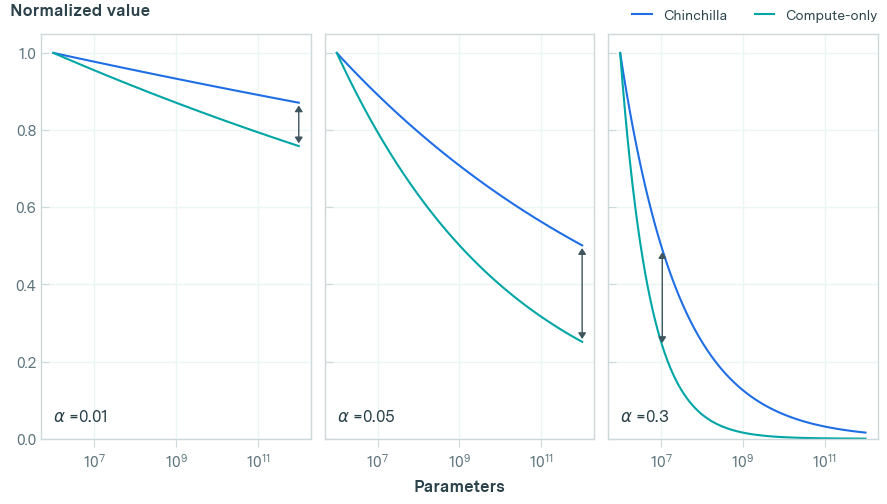

In [58]:
with egraphs.epoch_theme():
  alphas = [0.01, 0.05, 0.3]
  fig, ax = plt.subplots(1, len(alphas), figsize=egraphs.px_to_in((648, 376)), sharey=True)
  for i, alpha in enumerate(alphas):
    chinchilla_vals, compute_scale_vals = chinchilla_scale(param_vals, alpha), compute_scale(param_vals, alpha)
    chinchilla_vals /= max(chinchilla_vals)
    compute_scale_vals /= max(compute_scale_vals)

    ax[i].plot(param_vals, chinchilla_vals, label="Chinchilla", color='#1F6EE5')
    ax[i].plot(param_vals, compute_scale_vals, label="Compute-only", color='#00A5A6')
    ax[i].text(0.045, 0.035, r"$\alpha$ =" + str(alpha), transform=ax[i].transAxes, fontsize=12, verticalalignment='bottom')
    ax[i].set_xscale("log")
    ax[i].set_ylim(0, 1.05)
    ax[i].tick_params(axis='both', which='major')

    gap_index = np.argmax(chinchilla_vals - compute_scale_vals)
    x_pos = param_vals[gap_index]
    y_start = compute_scale_vals[gap_index]
    y_end = chinchilla_vals[gap_index]

    arrow_style = "<|-|>,head_width=0.23,head_length=0.35"

    ax[i].annotate('', xy=(x_pos, y_start), xytext=(x_pos, y_end),
                    arrowprops=dict(arrowstyle=arrow_style, color="#3E555E", lw=1))


  ax[0].set_ylabel('Normalized value')
  ax[1].set_xlabel('Parameters')
  ax[2].legend()

  egraphs.relayout()

  plt.gcf().subplots_adjust(left=egraphs.px_to_x_fraction(10), right=1-egraphs.px_to_x_fraction(5))

  plt.savefig("compute-model-scaling.pdf")
  plt.show()